# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 37kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

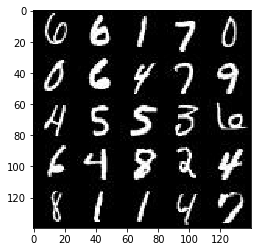

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

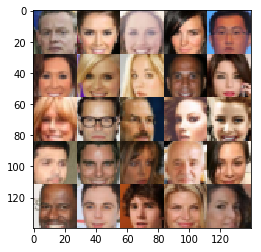

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='real_inputs')
    z_input = tf.placeholder(tf.float32,(None,z_dim),name='z_input')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.08
    keep_prob=0.8
    
    with tf.variable_scope('discriminator',reuse=reuse):
        conv1 = tf.layers.conv2d(images,64,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = tf.nn.dropout(conv1,keep_prob=keep_prob)
        conv1 = tf.maximum(alpha*conv1,conv1)
        
        conv2 = tf.layers.conv2d(conv1,128,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv2 = tf.layers.batch_normalization(conv2,training=True)
        conv2 = tf.maximum(alpha*conv2,conv2)
        conv2 = tf.nn.dropout(conv2,keep_prob=keep_prob)

        
        conv3 = tf.layers.conv2d(conv2,256,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv3 = tf.layers.batch_normalization(conv3,training=True)
        conv3 = tf.maximum(alpha*conv3,conv3)
        conv3 = tf.nn.dropout(conv3,keep_prob=keep_prob)
        
        flatten = tf.reshape(conv3,(-1,4*4*512))
        logits = tf.layers.dense(flatten,1,kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        logits = tf.nn.dropout(logits,keep_prob=keep_prob)
        output = tf.sigmoid(logits)
        
    return output, logits
#changed the order of dropout to (CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout -> CONV/FC) based on feedback 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.08
    keep_prob=0.8
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not(is_train)):
        layer1 = tf.layers.dense(z,7*7*1024,kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        layer1 = tf.reshape(layer1,(-1,7,7,1024))
        layer1 = tf.layers.batch_normalization(layer1,training=True)
        layer1 = tf.maximum(alpha*layer1,layer1)
        
        conv1 = tf.layers.conv2d_transpose(layer1,512,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = tf.layers.batch_normalization(conv1,training=True)
        conv1 = tf.maximum(alpha*conv1,conv1)
        conv1 = tf.nn.dropout(conv1,keep_prob=keep_prob)
        
        conv2 = tf.layers.conv2d_transpose(conv1,256,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv2 = tf.layers.batch_normalization(conv2,training=True)
        conv2 = tf.maximum(alpha*conv2,conv2)
        conv2 = tf.nn.dropout(conv2,keep_prob=keep_prob)
        
        conv3 = tf.layers.conv2d_transpose(conv1,128,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv3 = tf.layers.batch_normalization(conv3,training=True)
        conv3 = tf.maximum(alpha*conv3,conv3)
        conv3 = tf.nn.dropout(conv3,keep_prob=keep_prob)        
        
        logits = tf.layers.conv2d_transpose(conv3,out_channel_dim,5,strides=1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
       # logits = tf.nn.dropout(logits,keep_prob=keep_prob)
        output = tf.tanh(logits)
#increased the number of conv layers based on feedback         
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    generator_model = generator(input_z, out_channel_dim, is_train=True)
    dis_model_real, dis_logit_real  = discriminator(input_real, reuse=False)
    dis_model_fake, dis_logit_fake  = discriminator(generator_model, reuse=True)
    
    dis_labels_real = tf.ones_like(dis_logit_real) * (1-smooth)
    dis_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logit_real, labels=dis_labels_real))
    
    dis_labels_fake = tf.zeros_like(dis_logit_fake) * (1-smooth)
    dis_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logit_fake, labels=dis_labels_fake))
    
    dis_total_loss = dis_real_loss + dis_fake_loss
    
    gen_labels = tf.ones_like(dis_model_fake)
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logit_fake, labels=gen_labels) )  
    
    return dis_total_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(None):
        
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss,var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss,var_list = g_vars)

    return d_train_opt, g_train_opt

# added     with tf.control_dependencies(None) based on feedback 
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:


def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    counter = 0
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    dis_opt, gen_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                counter += 1
                batch_images =batch_images*2
                batch_z_dim = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(dis_opt, feed_dict={input_real: batch_images, input_z: batch_z_dim, learn_rate:learning_rate})
                sess.run(gen_opt, feed_dict={input_real: batch_images, input_z: batch_z_dim, learn_rate:learning_rate})           
                
                if counter % 10 == 0:
                    dis_train_loss = d_loss.eval({input_z: batch_z_dim, input_real: batch_images})
                    gen_train_loss = g_loss.eval({input_z: batch_z_dim})
                    
                    print("Generator Loss: {:.4f}".format(gen_train_loss),
                          "........ Discriminator Loss: {:.4f}".format(dis_train_loss))
                    
                if counter % 100 == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Generator Loss: 4.5107 ........ Discriminator Loss: 1.0316
Generator Loss: 2.0161 ........ Discriminator Loss: 0.7805
Generator Loss: 2.5711 ........ Discriminator Loss: 0.8451
Generator Loss: 0.1597 ........ Discriminator Loss: 3.0173
Generator Loss: 6.6434 ........ Discriminator Loss: 0.4988
Generator Loss: 4.4658 ........ Discriminator Loss: 1.2553
Generator Loss: 0.8358 ........ Discriminator Loss: 5.2057
Generator Loss: 0.8570 ........ Discriminator Loss: 1.8740
Generator Loss: 1.0748 ........ Discriminator Loss: 2.0530
Generator Loss: 1.2676 ........ Discriminator Loss: 1.8042


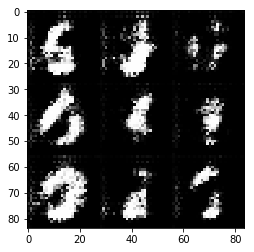

Generator Loss: 0.6545 ........ Discriminator Loss: 2.2845
Generator Loss: 0.3153 ........ Discriminator Loss: 2.0922
Generator Loss: 1.8765 ........ Discriminator Loss: 1.8801
Generator Loss: 0.8042 ........ Discriminator Loss: 1.7961
Generator Loss: 0.8688 ........ Discriminator Loss: 1.9393
Generator Loss: 0.4980 ........ Discriminator Loss: 2.1859
Generator Loss: 1.4633 ........ Discriminator Loss: 1.3289
Generator Loss: 0.6220 ........ Discriminator Loss: 2.5919
Generator Loss: 2.1869 ........ Discriminator Loss: 2.0741
Generator Loss: 0.8871 ........ Discriminator Loss: 2.0262


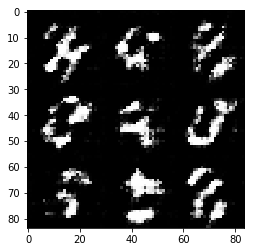

Generator Loss: 0.7486 ........ Discriminator Loss: 1.4468
Generator Loss: 0.3233 ........ Discriminator Loss: 3.2002
Generator Loss: 0.7006 ........ Discriminator Loss: 1.6462
Generator Loss: 1.1045 ........ Discriminator Loss: 1.1052
Generator Loss: 1.6664 ........ Discriminator Loss: 1.4592
Generator Loss: 0.4542 ........ Discriminator Loss: 1.9724
Generator Loss: 0.7115 ........ Discriminator Loss: 1.3320
Generator Loss: 1.2187 ........ Discriminator Loss: 1.5881
Generator Loss: 1.5587 ........ Discriminator Loss: 1.3463
Generator Loss: 0.7069 ........ Discriminator Loss: 1.3648


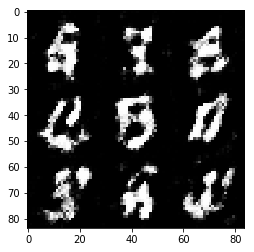

Generator Loss: 0.9417 ........ Discriminator Loss: 1.5875
Generator Loss: 1.0044 ........ Discriminator Loss: 1.3101
Generator Loss: 1.7237 ........ Discriminator Loss: 0.6529
Generator Loss: 0.9951 ........ Discriminator Loss: 1.4432
Generator Loss: 0.2976 ........ Discriminator Loss: 1.8294
Generator Loss: 0.8988 ........ Discriminator Loss: 1.2086
Generator Loss: 1.1540 ........ Discriminator Loss: 1.5485
Generator Loss: 0.5088 ........ Discriminator Loss: 1.4772
Generator Loss: 0.5329 ........ Discriminator Loss: 1.5655
Generator Loss: 1.1893 ........ Discriminator Loss: 1.2739


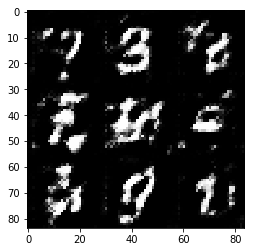

Generator Loss: 1.6305 ........ Discriminator Loss: 1.4927
Generator Loss: 1.4167 ........ Discriminator Loss: 1.2422
Generator Loss: 1.2504 ........ Discriminator Loss: 1.2169
Generator Loss: 0.8293 ........ Discriminator Loss: 1.3195
Generator Loss: 0.4751 ........ Discriminator Loss: 1.7089
Generator Loss: 0.6943 ........ Discriminator Loss: 1.4481
Generator Loss: 1.2020 ........ Discriminator Loss: 1.1967
Generator Loss: 0.3180 ........ Discriminator Loss: 1.8209
Generator Loss: 1.7275 ........ Discriminator Loss: 1.3851
Generator Loss: 1.4590 ........ Discriminator Loss: 1.2889


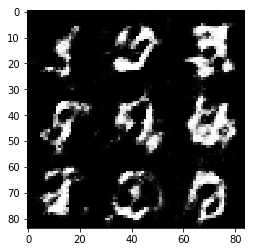

Generator Loss: 0.8011 ........ Discriminator Loss: 1.4117
Generator Loss: 0.8873 ........ Discriminator Loss: 1.7402
Generator Loss: 1.0498 ........ Discriminator Loss: 1.1025
Generator Loss: 1.8276 ........ Discriminator Loss: 1.1702
Generator Loss: 1.0226 ........ Discriminator Loss: 1.7447
Generator Loss: 0.6713 ........ Discriminator Loss: 1.8135
Generator Loss: 2.0153 ........ Discriminator Loss: 1.2556
Generator Loss: 0.6864 ........ Discriminator Loss: 1.2057
Generator Loss: 0.6476 ........ Discriminator Loss: 1.4817
Generator Loss: 2.3652 ........ Discriminator Loss: 1.3118


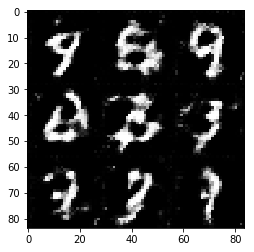

Generator Loss: 1.3240 ........ Discriminator Loss: 1.4258
Generator Loss: 1.3325 ........ Discriminator Loss: 1.3567
Generator Loss: 0.4448 ........ Discriminator Loss: 1.3994
Generator Loss: 2.7377 ........ Discriminator Loss: 1.3058
Generator Loss: 1.1322 ........ Discriminator Loss: 1.2335
Generator Loss: 1.0594 ........ Discriminator Loss: 1.2184
Generator Loss: 1.1189 ........ Discriminator Loss: 1.7681
Generator Loss: 0.7544 ........ Discriminator Loss: 1.3438
Generator Loss: 1.3049 ........ Discriminator Loss: 0.9548
Generator Loss: 1.1468 ........ Discriminator Loss: 1.2156


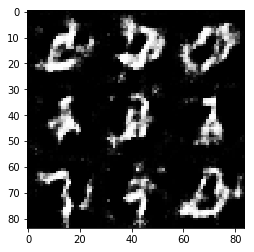

Generator Loss: 0.4358 ........ Discriminator Loss: 2.4463
Generator Loss: 0.5232 ........ Discriminator Loss: 1.6535
Generator Loss: 0.9029 ........ Discriminator Loss: 1.3941
Generator Loss: 0.7635 ........ Discriminator Loss: 1.5470
Generator Loss: 1.3124 ........ Discriminator Loss: 1.3530
Generator Loss: 0.9488 ........ Discriminator Loss: 1.5571
Generator Loss: 0.5816 ........ Discriminator Loss: 1.9676
Generator Loss: 0.6453 ........ Discriminator Loss: 1.4516
Generator Loss: 1.5785 ........ Discriminator Loss: 1.0932
Generator Loss: 0.6658 ........ Discriminator Loss: 1.7453


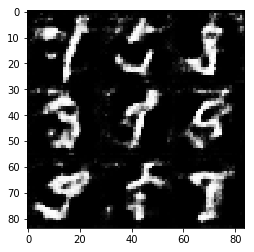

Generator Loss: 1.2876 ........ Discriminator Loss: 1.1728
Generator Loss: 0.9885 ........ Discriminator Loss: 1.1662
Generator Loss: 0.7814 ........ Discriminator Loss: 1.5572
Generator Loss: 0.6467 ........ Discriminator Loss: 1.5392
Generator Loss: 0.5192 ........ Discriminator Loss: 1.4338
Generator Loss: 0.8943 ........ Discriminator Loss: 1.1904
Generator Loss: 0.6603 ........ Discriminator Loss: 2.3114
Generator Loss: 0.7436 ........ Discriminator Loss: 1.5291
Generator Loss: 0.7568 ........ Discriminator Loss: 1.5493
Generator Loss: 1.2175 ........ Discriminator Loss: 0.9250


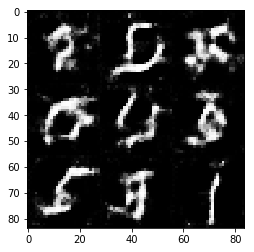

Generator Loss: 0.4898 ........ Discriminator Loss: 1.5796
Generator Loss: 1.1344 ........ Discriminator Loss: 1.1565
Generator Loss: 0.7787 ........ Discriminator Loss: 1.6207
Generator Loss: 0.8627 ........ Discriminator Loss: 1.1640
Generator Loss: 1.4079 ........ Discriminator Loss: 1.1055
Generator Loss: 1.1667 ........ Discriminator Loss: 1.2597
Generator Loss: 1.2197 ........ Discriminator Loss: 1.4858
Generator Loss: 0.6670 ........ Discriminator Loss: 1.8389
Generator Loss: 0.6679 ........ Discriminator Loss: 1.4520
Generator Loss: 0.9664 ........ Discriminator Loss: 1.3776


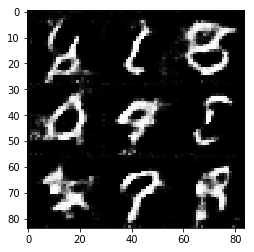

Generator Loss: 1.6751 ........ Discriminator Loss: 1.6749
Generator Loss: 0.7407 ........ Discriminator Loss: 1.3494
Generator Loss: 1.0169 ........ Discriminator Loss: 1.1289
Generator Loss: 0.6275 ........ Discriminator Loss: 1.6196
Generator Loss: 0.6220 ........ Discriminator Loss: 1.6398
Generator Loss: 0.9230 ........ Discriminator Loss: 1.5094
Generator Loss: 0.5795 ........ Discriminator Loss: 1.6623
Generator Loss: 0.3793 ........ Discriminator Loss: 1.7062
Generator Loss: 1.7065 ........ Discriminator Loss: 1.2432
Generator Loss: 0.9970 ........ Discriminator Loss: 1.5212


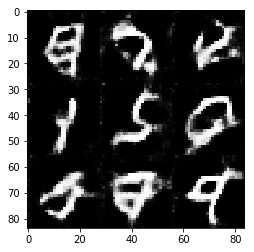

Generator Loss: 1.0812 ........ Discriminator Loss: 1.1592
Generator Loss: 0.6463 ........ Discriminator Loss: 1.6415
Generator Loss: 0.9192 ........ Discriminator Loss: 1.3000
Generator Loss: 0.8893 ........ Discriminator Loss: 1.2727
Generator Loss: 1.3966 ........ Discriminator Loss: 1.7724
Generator Loss: 0.8699 ........ Discriminator Loss: 1.0498
Generator Loss: 1.7100 ........ Discriminator Loss: 1.4507
Generator Loss: 0.3262 ........ Discriminator Loss: 1.5893
Generator Loss: 1.0606 ........ Discriminator Loss: 1.3475
Generator Loss: 0.7288 ........ Discriminator Loss: 1.3056


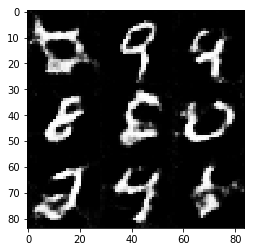

Generator Loss: 0.5010 ........ Discriminator Loss: 1.2894
Generator Loss: 0.6386 ........ Discriminator Loss: 1.2931
Generator Loss: 0.9105 ........ Discriminator Loss: 1.1498
Generator Loss: 2.0444 ........ Discriminator Loss: 1.2694
Generator Loss: 0.9717 ........ Discriminator Loss: 1.7737
Generator Loss: 0.6193 ........ Discriminator Loss: 1.2330
Generator Loss: 0.5198 ........ Discriminator Loss: 1.5133
Generator Loss: 1.0274 ........ Discriminator Loss: 1.3232
Generator Loss: 0.9238 ........ Discriminator Loss: 1.2201
Generator Loss: 0.6482 ........ Discriminator Loss: 1.8583


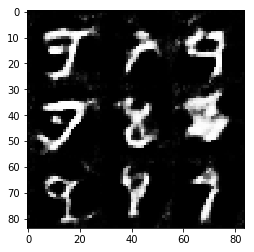

Generator Loss: 1.6245 ........ Discriminator Loss: 1.0737
Generator Loss: 1.3684 ........ Discriminator Loss: 1.1162
Generator Loss: 0.5314 ........ Discriminator Loss: 1.5271
Generator Loss: 0.7833 ........ Discriminator Loss: 1.1044
Generator Loss: 1.0641 ........ Discriminator Loss: 1.1882
Generator Loss: 0.7073 ........ Discriminator Loss: 1.2353
Generator Loss: 1.5547 ........ Discriminator Loss: 1.3297
Generator Loss: 1.1539 ........ Discriminator Loss: 1.5916
Generator Loss: 1.7964 ........ Discriminator Loss: 1.1180
Generator Loss: 0.7240 ........ Discriminator Loss: 1.0548


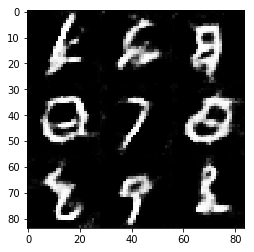

Generator Loss: 0.7916 ........ Discriminator Loss: 1.2475
Generator Loss: 2.2806 ........ Discriminator Loss: 1.3730
Generator Loss: 0.5744 ........ Discriminator Loss: 1.1527
Generator Loss: 0.4702 ........ Discriminator Loss: 1.3854
Generator Loss: 0.8986 ........ Discriminator Loss: 1.2002
Generator Loss: 0.6599 ........ Discriminator Loss: 1.6034
Generator Loss: 0.6673 ........ Discriminator Loss: 1.3360
Generator Loss: 1.2340 ........ Discriminator Loss: 1.2845
Generator Loss: 0.6162 ........ Discriminator Loss: 1.5248
Generator Loss: 1.0374 ........ Discriminator Loss: 0.9792


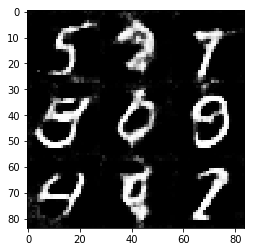

Generator Loss: 1.3817 ........ Discriminator Loss: 1.8541
Generator Loss: 0.8040 ........ Discriminator Loss: 1.4363
Generator Loss: 1.2326 ........ Discriminator Loss: 1.4397
Generator Loss: 1.1303 ........ Discriminator Loss: 1.1016
Generator Loss: 1.3817 ........ Discriminator Loss: 1.2962
Generator Loss: 0.9098 ........ Discriminator Loss: 1.1786
Generator Loss: 0.5575 ........ Discriminator Loss: 1.3079
Generator Loss: 0.7547 ........ Discriminator Loss: 1.0065
Generator Loss: 0.8383 ........ Discriminator Loss: 1.4053
Generator Loss: 1.7224 ........ Discriminator Loss: 1.2208


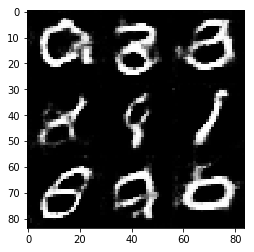

Generator Loss: 1.0030 ........ Discriminator Loss: 1.1088
Generator Loss: 1.5574 ........ Discriminator Loss: 1.2724
Generator Loss: 1.1175 ........ Discriminator Loss: 1.2748
Generator Loss: 0.5786 ........ Discriminator Loss: 1.5404
Generator Loss: 0.6741 ........ Discriminator Loss: 1.6466
Generator Loss: 1.9403 ........ Discriminator Loss: 1.5783
Generator Loss: 0.7537 ........ Discriminator Loss: 1.4704
Generator Loss: 0.9154 ........ Discriminator Loss: 1.2226
Generator Loss: 1.6386 ........ Discriminator Loss: 1.2538
Generator Loss: 0.5799 ........ Discriminator Loss: 1.5435


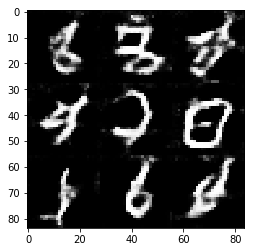

Generator Loss: 0.6236 ........ Discriminator Loss: 1.6730
Generator Loss: 0.8470 ........ Discriminator Loss: 1.2358
Generator Loss: 0.7146 ........ Discriminator Loss: 1.6125
Generator Loss: 0.7880 ........ Discriminator Loss: 1.3825
Generator Loss: 0.9639 ........ Discriminator Loss: 1.1902
Generator Loss: 0.5695 ........ Discriminator Loss: 1.6061
Generator Loss: 0.7054 ........ Discriminator Loss: 1.0779
Generator Loss: 0.8594 ........ Discriminator Loss: 1.1895
Generator Loss: 0.6874 ........ Discriminator Loss: 1.2124
Generator Loss: 0.5831 ........ Discriminator Loss: 1.3820


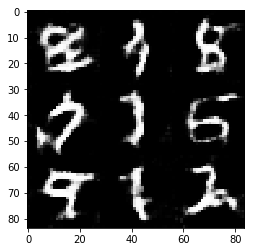

Generator Loss: 1.2797 ........ Discriminator Loss: 1.0165
Generator Loss: 0.6947 ........ Discriminator Loss: 1.7240
Generator Loss: 1.1568 ........ Discriminator Loss: 1.2335
Generator Loss: 0.6477 ........ Discriminator Loss: 1.0502
Generator Loss: 0.9635 ........ Discriminator Loss: 1.2201
Generator Loss: 1.4256 ........ Discriminator Loss: 1.2862
Generator Loss: 0.9852 ........ Discriminator Loss: 1.2264
Generator Loss: 0.4781 ........ Discriminator Loss: 1.6893
Generator Loss: 1.1091 ........ Discriminator Loss: 1.0832
Generator Loss: 0.9169 ........ Discriminator Loss: 1.4691


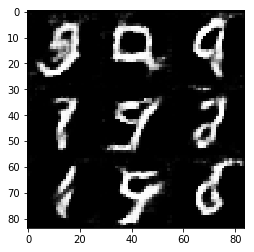

Generator Loss: 0.8792 ........ Discriminator Loss: 1.0745
Generator Loss: 0.7289 ........ Discriminator Loss: 1.2448
Generator Loss: 0.8212 ........ Discriminator Loss: 1.5426
Generator Loss: 0.8095 ........ Discriminator Loss: 1.2997
Generator Loss: 0.6198 ........ Discriminator Loss: 1.1921
Generator Loss: 0.9017 ........ Discriminator Loss: 1.2035
Generator Loss: 0.6576 ........ Discriminator Loss: 1.1392
Generator Loss: 0.7386 ........ Discriminator Loss: 1.4191
Generator Loss: 1.1931 ........ Discriminator Loss: 1.4025
Generator Loss: 0.6085 ........ Discriminator Loss: 1.6176


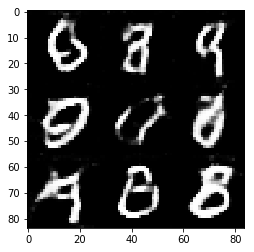

Generator Loss: 1.0727 ........ Discriminator Loss: 1.3588
Generator Loss: 1.0665 ........ Discriminator Loss: 1.3472
Generator Loss: 1.0001 ........ Discriminator Loss: 1.1946
Generator Loss: 0.9762 ........ Discriminator Loss: 1.1480
Generator Loss: 1.0335 ........ Discriminator Loss: 1.1719
Generator Loss: 1.2649 ........ Discriminator Loss: 1.2761
Generator Loss: 0.5714 ........ Discriminator Loss: 1.4179
Generator Loss: 0.7085 ........ Discriminator Loss: 1.0234
Generator Loss: 0.6393 ........ Discriminator Loss: 1.3049
Generator Loss: 0.8346 ........ Discriminator Loss: 1.3718


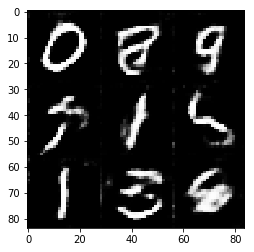

Generator Loss: 0.9210 ........ Discriminator Loss: 1.2856
Generator Loss: 0.9217 ........ Discriminator Loss: 0.9976
Generator Loss: 1.3765 ........ Discriminator Loss: 1.4999
Generator Loss: 1.5772 ........ Discriminator Loss: 1.2169
Generator Loss: 0.9123 ........ Discriminator Loss: 1.4733
Generator Loss: 0.6824 ........ Discriminator Loss: 1.2849
Generator Loss: 0.7450 ........ Discriminator Loss: 1.4327
Generator Loss: 0.7191 ........ Discriminator Loss: 1.0721
Generator Loss: 0.8133 ........ Discriminator Loss: 1.3271
Generator Loss: 0.8763 ........ Discriminator Loss: 1.1268


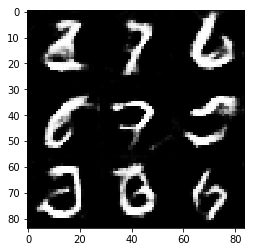

Generator Loss: 0.9975 ........ Discriminator Loss: 1.5010
Generator Loss: 0.6132 ........ Discriminator Loss: 1.2926
Generator Loss: 0.8110 ........ Discriminator Loss: 1.1355
Generator Loss: 1.6870 ........ Discriminator Loss: 1.2856
Generator Loss: 0.6799 ........ Discriminator Loss: 1.4592
Generator Loss: 1.0509 ........ Discriminator Loss: 1.1870
Generator Loss: 0.8760 ........ Discriminator Loss: 1.5509
Generator Loss: 0.6019 ........ Discriminator Loss: 1.3975
Generator Loss: 0.6613 ........ Discriminator Loss: 1.3431
Generator Loss: 0.6743 ........ Discriminator Loss: 1.4612


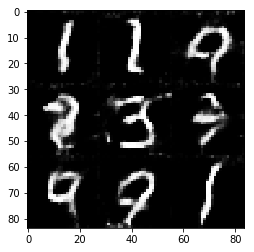

Generator Loss: 0.5944 ........ Discriminator Loss: 1.4479
Generator Loss: 1.1728 ........ Discriminator Loss: 1.0687
Generator Loss: 1.3422 ........ Discriminator Loss: 1.4940
Generator Loss: 0.9519 ........ Discriminator Loss: 1.2452
Generator Loss: 0.4494 ........ Discriminator Loss: 1.7242
Generator Loss: 1.1783 ........ Discriminator Loss: 1.2264
Generator Loss: 0.5750 ........ Discriminator Loss: 1.5181
Generator Loss: 0.9941 ........ Discriminator Loss: 1.1840
Generator Loss: 1.6046 ........ Discriminator Loss: 1.1615
Generator Loss: 0.9231 ........ Discriminator Loss: 1.2628


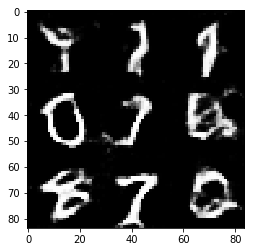

Generator Loss: 1.6670 ........ Discriminator Loss: 1.1071
Generator Loss: 0.8665 ........ Discriminator Loss: 1.4449
Generator Loss: 0.8134 ........ Discriminator Loss: 1.2133
Generator Loss: 0.5487 ........ Discriminator Loss: 1.4221
Generator Loss: 1.2106 ........ Discriminator Loss: 0.9903
Generator Loss: 1.1991 ........ Discriminator Loss: 1.0660
Generator Loss: 1.3024 ........ Discriminator Loss: 1.0782
Generator Loss: 0.8741 ........ Discriminator Loss: 1.3764
Generator Loss: 0.8598 ........ Discriminator Loss: 1.2024
Generator Loss: 1.4458 ........ Discriminator Loss: 1.0027


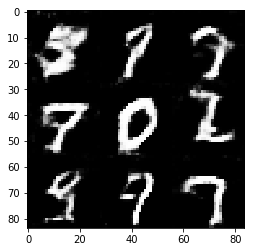

Generator Loss: 0.6303 ........ Discriminator Loss: 1.4624
Generator Loss: 0.8803 ........ Discriminator Loss: 1.3538
Generator Loss: 0.5921 ........ Discriminator Loss: 1.6357
Generator Loss: 2.1023 ........ Discriminator Loss: 1.3923
Generator Loss: 0.9000 ........ Discriminator Loss: 0.9479
Generator Loss: 1.1202 ........ Discriminator Loss: 1.3717
Generator Loss: 0.6407 ........ Discriminator Loss: 1.4467
Generator Loss: 2.3669 ........ Discriminator Loss: 1.3443
Generator Loss: 1.1345 ........ Discriminator Loss: 1.3160
Generator Loss: 0.5113 ........ Discriminator Loss: 1.9968


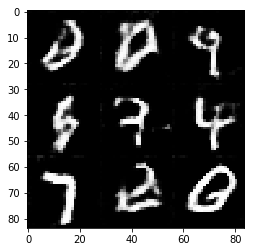

Generator Loss: 1.5496 ........ Discriminator Loss: 1.6494
Generator Loss: 1.1781 ........ Discriminator Loss: 1.2025
Generator Loss: 0.5576 ........ Discriminator Loss: 1.7374
Generator Loss: 1.0693 ........ Discriminator Loss: 1.1211
Generator Loss: 1.0275 ........ Discriminator Loss: 1.0475
Generator Loss: 0.7906 ........ Discriminator Loss: 1.6199
Generator Loss: 0.3739 ........ Discriminator Loss: 1.6819
Generator Loss: 0.8303 ........ Discriminator Loss: 1.3374
Generator Loss: 1.8119 ........ Discriminator Loss: 1.3788
Generator Loss: 0.7675 ........ Discriminator Loss: 1.1475


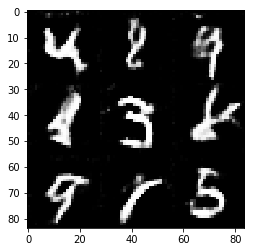

Generator Loss: 0.8927 ........ Discriminator Loss: 1.2216
Generator Loss: 0.6539 ........ Discriminator Loss: 1.5400
Generator Loss: 1.0058 ........ Discriminator Loss: 1.2011
Generator Loss: 1.2891 ........ Discriminator Loss: 1.5619
Generator Loss: 0.6464 ........ Discriminator Loss: 1.7259
Generator Loss: 0.7157 ........ Discriminator Loss: 1.3176
Generator Loss: 0.8157 ........ Discriminator Loss: 1.1900
Generator Loss: 0.7343 ........ Discriminator Loss: 1.8437
Generator Loss: 0.4359 ........ Discriminator Loss: 1.3135
Generator Loss: 0.7989 ........ Discriminator Loss: 1.7067


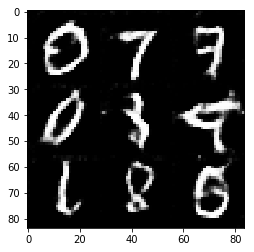

Generator Loss: 1.2431 ........ Discriminator Loss: 1.5156
Generator Loss: 1.0666 ........ Discriminator Loss: 1.4315
Generator Loss: 0.9480 ........ Discriminator Loss: 1.4857
Generator Loss: 0.6484 ........ Discriminator Loss: 1.8283
Generator Loss: 0.6753 ........ Discriminator Loss: 1.5670
Generator Loss: 0.5402 ........ Discriminator Loss: 1.4639
Generator Loss: 0.6244 ........ Discriminator Loss: 1.4455
Generator Loss: 1.0739 ........ Discriminator Loss: 1.0929
Generator Loss: 0.5450 ........ Discriminator Loss: 1.7547
Generator Loss: 1.1951 ........ Discriminator Loss: 1.3036


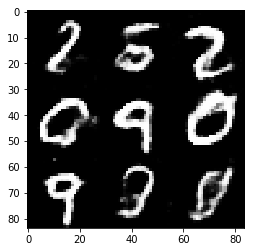

Generator Loss: 0.5291 ........ Discriminator Loss: 1.5583
Generator Loss: 0.7894 ........ Discriminator Loss: 1.3755
Generator Loss: 0.4755 ........ Discriminator Loss: 1.2364
Generator Loss: 0.6749 ........ Discriminator Loss: 1.0468
Generator Loss: 0.7197 ........ Discriminator Loss: 1.3593
Generator Loss: 0.9812 ........ Discriminator Loss: 1.4366
Generator Loss: 1.0253 ........ Discriminator Loss: 1.1923
Generator Loss: 0.7007 ........ Discriminator Loss: 1.5985
Generator Loss: 1.6650 ........ Discriminator Loss: 1.1845
Generator Loss: 0.5176 ........ Discriminator Loss: 1.7916


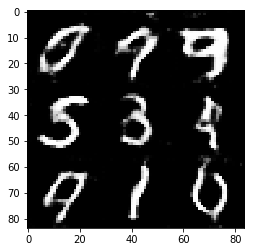

Generator Loss: 1.2094 ........ Discriminator Loss: 1.2944
Generator Loss: 0.8334 ........ Discriminator Loss: 1.4433
Generator Loss: 0.6549 ........ Discriminator Loss: 1.1683
Generator Loss: 1.0938 ........ Discriminator Loss: 1.4899
Generator Loss: 0.7992 ........ Discriminator Loss: 1.5262
Generator Loss: 0.6049 ........ Discriminator Loss: 1.4128
Generator Loss: 0.6790 ........ Discriminator Loss: 1.2630
Generator Loss: 1.0505 ........ Discriminator Loss: 1.2071
Generator Loss: 0.5319 ........ Discriminator Loss: 1.4504
Generator Loss: 0.7585 ........ Discriminator Loss: 1.6673


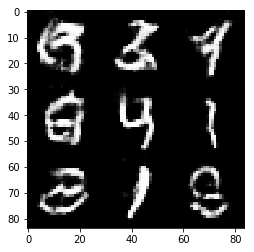

Generator Loss: 0.4149 ........ Discriminator Loss: 1.5186
Generator Loss: 1.0032 ........ Discriminator Loss: 1.0404
Generator Loss: 1.3423 ........ Discriminator Loss: 1.3015
Generator Loss: 1.5637 ........ Discriminator Loss: 1.0959
Generator Loss: 0.5993 ........ Discriminator Loss: 1.3424
Generator Loss: 1.1914 ........ Discriminator Loss: 1.2215
Generator Loss: 1.3696 ........ Discriminator Loss: 1.6194
Generator Loss: 0.7659 ........ Discriminator Loss: 1.2503
Generator Loss: 1.2801 ........ Discriminator Loss: 1.0949
Generator Loss: 0.8639 ........ Discriminator Loss: 1.0870


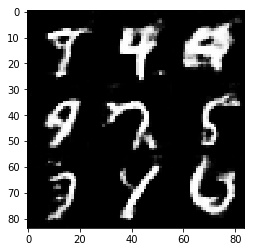

Generator Loss: 0.6114 ........ Discriminator Loss: 1.2558
Generator Loss: 0.9686 ........ Discriminator Loss: 1.2980
Generator Loss: 1.0848 ........ Discriminator Loss: 0.9745
Generator Loss: 1.2907 ........ Discriminator Loss: 1.1409
Generator Loss: 0.8746 ........ Discriminator Loss: 1.2846
Generator Loss: 0.9597 ........ Discriminator Loss: 1.1985
Generator Loss: 0.8879 ........ Discriminator Loss: 1.6770
Generator Loss: 0.5315 ........ Discriminator Loss: 1.7847
Generator Loss: 1.2842 ........ Discriminator Loss: 1.4477
Generator Loss: 0.7421 ........ Discriminator Loss: 1.2955


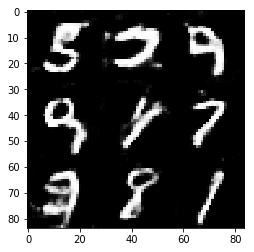

Generator Loss: 0.8869 ........ Discriminator Loss: 1.4417
Generator Loss: 1.6407 ........ Discriminator Loss: 1.2760
Generator Loss: 1.3533 ........ Discriminator Loss: 1.2113
Generator Loss: 0.6058 ........ Discriminator Loss: 1.2082
Generator Loss: 0.5351 ........ Discriminator Loss: 1.4998
Generator Loss: 0.7730 ........ Discriminator Loss: 1.0125
Generator Loss: 0.9277 ........ Discriminator Loss: 1.0958
Generator Loss: 0.6431 ........ Discriminator Loss: 1.6782
Generator Loss: 0.5983 ........ Discriminator Loss: 1.4840
Generator Loss: 0.6727 ........ Discriminator Loss: 1.1973


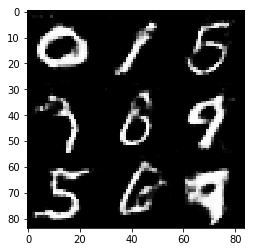

Generator Loss: 0.9465 ........ Discriminator Loss: 1.2184
Generator Loss: 0.9558 ........ Discriminator Loss: 1.3871
Generator Loss: 0.4246 ........ Discriminator Loss: 1.7914
Generator Loss: 1.8299 ........ Discriminator Loss: 1.2559
Generator Loss: 1.6640 ........ Discriminator Loss: 1.1183
Generator Loss: 1.0728 ........ Discriminator Loss: 1.2852
Generator Loss: 0.6260 ........ Discriminator Loss: 1.5977
Generator Loss: 0.7185 ........ Discriminator Loss: 1.3019
Generator Loss: 1.3836 ........ Discriminator Loss: 1.2266
Generator Loss: 0.8420 ........ Discriminator Loss: 0.9699


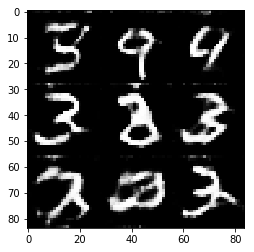

Generator Loss: 0.6802 ........ Discriminator Loss: 1.2021
Generator Loss: 0.8126 ........ Discriminator Loss: 1.3281
Generator Loss: 1.1480 ........ Discriminator Loss: 1.1442
Generator Loss: 1.2335 ........ Discriminator Loss: 1.2708
Generator Loss: 0.9445 ........ Discriminator Loss: 1.1273
Generator Loss: 0.8464 ........ Discriminator Loss: 1.1235
Generator Loss: 0.9479 ........ Discriminator Loss: 1.2346
Generator Loss: 1.3030 ........ Discriminator Loss: 1.2770
Generator Loss: 0.8551 ........ Discriminator Loss: 1.7504
Generator Loss: 1.0204 ........ Discriminator Loss: 1.3476


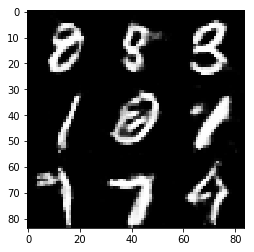

Generator Loss: 1.0662 ........ Discriminator Loss: 1.3888
Generator Loss: 0.8951 ........ Discriminator Loss: 1.2137
Generator Loss: 0.8072 ........ Discriminator Loss: 1.6103
Generator Loss: 1.0268 ........ Discriminator Loss: 1.0774
Generator Loss: 1.1871 ........ Discriminator Loss: 1.3794
Generator Loss: 0.9376 ........ Discriminator Loss: 1.0827
Generator Loss: 0.4622 ........ Discriminator Loss: 1.6802
Generator Loss: 0.9565 ........ Discriminator Loss: 1.2152
Generator Loss: 1.0614 ........ Discriminator Loss: 0.9688
Generator Loss: 1.0224 ........ Discriminator Loss: 1.2382


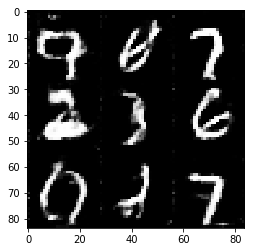

Generator Loss: 0.7840 ........ Discriminator Loss: 1.3135
Generator Loss: 0.8131 ........ Discriminator Loss: 1.1512
Generator Loss: 1.1652 ........ Discriminator Loss: 1.2057
Generator Loss: 0.5470 ........ Discriminator Loss: 1.1955
Generator Loss: 0.5889 ........ Discriminator Loss: 1.7420
Generator Loss: 0.6799 ........ Discriminator Loss: 1.3836
Generator Loss: 0.9359 ........ Discriminator Loss: 1.1807
Generator Loss: 0.5837 ........ Discriminator Loss: 1.1985
Generator Loss: 0.8770 ........ Discriminator Loss: 1.2296
Generator Loss: 0.7965 ........ Discriminator Loss: 1.2582


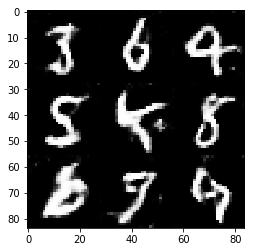

Generator Loss: 0.9942 ........ Discriminator Loss: 1.1004
Generator Loss: 1.0750 ........ Discriminator Loss: 1.2177
Generator Loss: 0.9623 ........ Discriminator Loss: 1.5318
Generator Loss: 0.7354 ........ Discriminator Loss: 1.1810
Generator Loss: 1.0681 ........ Discriminator Loss: 1.3769
Generator Loss: 1.0280 ........ Discriminator Loss: 1.2740
Generator Loss: 0.9990 ........ Discriminator Loss: 1.0044
Generator Loss: 0.4161 ........ Discriminator Loss: 1.7460
Generator Loss: 0.6507 ........ Discriminator Loss: 1.1908
Generator Loss: 1.0264 ........ Discriminator Loss: 1.2295


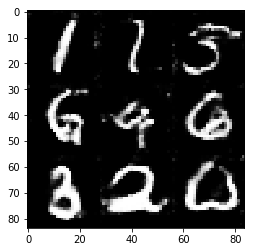

Generator Loss: 1.0575 ........ Discriminator Loss: 1.2931
Generator Loss: 1.0133 ........ Discriminator Loss: 1.1812
Generator Loss: 0.9482 ........ Discriminator Loss: 1.3325
Generator Loss: 1.2030 ........ Discriminator Loss: 1.0417
Generator Loss: 0.9977 ........ Discriminator Loss: 1.2411
Generator Loss: 0.5858 ........ Discriminator Loss: 1.4068
Generator Loss: 0.8103 ........ Discriminator Loss: 1.1578
Generator Loss: 1.5501 ........ Discriminator Loss: 1.3538
Generator Loss: 0.6984 ........ Discriminator Loss: 1.3804
Generator Loss: 0.8331 ........ Discriminator Loss: 1.2427


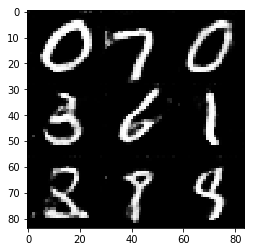

Generator Loss: 1.5450 ........ Discriminator Loss: 1.1087
Generator Loss: 1.4735 ........ Discriminator Loss: 1.1230
Generator Loss: 1.2367 ........ Discriminator Loss: 1.0771
Generator Loss: 1.1969 ........ Discriminator Loss: 1.0925
Generator Loss: 0.6771 ........ Discriminator Loss: 1.4943
Generator Loss: 0.9717 ........ Discriminator Loss: 1.1800
Generator Loss: 1.3173 ........ Discriminator Loss: 1.0643
Generator Loss: 1.2473 ........ Discriminator Loss: 1.3810
Generator Loss: 0.3513 ........ Discriminator Loss: 1.9534
Generator Loss: 1.1349 ........ Discriminator Loss: 1.1846


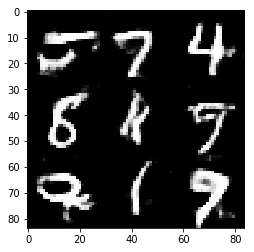

Generator Loss: 0.5055 ........ Discriminator Loss: 1.5740
Generator Loss: 0.7299 ........ Discriminator Loss: 1.3305
Generator Loss: 1.5903 ........ Discriminator Loss: 1.3789
Generator Loss: 0.8314 ........ Discriminator Loss: 1.2741
Generator Loss: 0.5772 ........ Discriminator Loss: 1.5826
Generator Loss: 0.6794 ........ Discriminator Loss: 1.2491
Generator Loss: 0.9058 ........ Discriminator Loss: 1.1450
Generator Loss: 0.7046 ........ Discriminator Loss: 1.3948
Generator Loss: 0.9787 ........ Discriminator Loss: 0.9906
Generator Loss: 1.2509 ........ Discriminator Loss: 1.0589


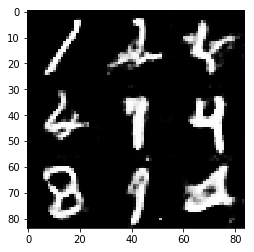

Generator Loss: 0.9194 ........ Discriminator Loss: 1.3322
Generator Loss: 0.8900 ........ Discriminator Loss: 1.2170
Generator Loss: 1.3219 ........ Discriminator Loss: 1.2365
Generator Loss: 0.6097 ........ Discriminator Loss: 1.3839
Generator Loss: 0.8566 ........ Discriminator Loss: 1.5032
Generator Loss: 0.9910 ........ Discriminator Loss: 1.3629
Generator Loss: 1.8281 ........ Discriminator Loss: 1.0518
Generator Loss: 0.6011 ........ Discriminator Loss: 1.0572
Generator Loss: 1.4611 ........ Discriminator Loss: 1.0569
Generator Loss: 0.6193 ........ Discriminator Loss: 1.3236


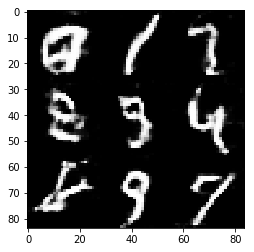

Generator Loss: 0.8607 ........ Discriminator Loss: 1.2966
Generator Loss: 0.6598 ........ Discriminator Loss: 1.4860
Generator Loss: 0.5894 ........ Discriminator Loss: 1.2610
Generator Loss: 1.0139 ........ Discriminator Loss: 1.1207
Generator Loss: 0.9715 ........ Discriminator Loss: 1.0929
Generator Loss: 0.9233 ........ Discriminator Loss: 1.1439
Generator Loss: 1.2059 ........ Discriminator Loss: 1.2323
Generator Loss: 1.4604 ........ Discriminator Loss: 0.9632
Generator Loss: 1.0648 ........ Discriminator Loss: 1.4768
Generator Loss: 0.7648 ........ Discriminator Loss: 1.0072


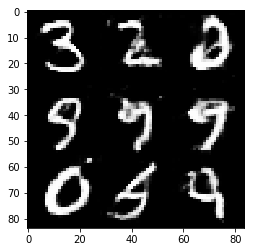

Generator Loss: 1.2521 ........ Discriminator Loss: 1.2881
Generator Loss: 1.1557 ........ Discriminator Loss: 1.1049
Generator Loss: 0.9866 ........ Discriminator Loss: 1.0527
Generator Loss: 1.1546 ........ Discriminator Loss: 0.9944
Generator Loss: 0.8771 ........ Discriminator Loss: 1.5755
Generator Loss: 0.4885 ........ Discriminator Loss: 1.4348
Generator Loss: 0.5595 ........ Discriminator Loss: 1.2422
Generator Loss: 0.5338 ........ Discriminator Loss: 1.5669
Generator Loss: 1.2892 ........ Discriminator Loss: 1.1004
Generator Loss: 1.2120 ........ Discriminator Loss: 1.3410


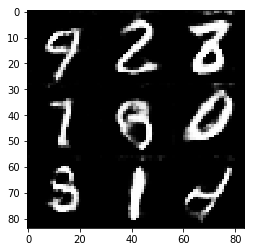

Generator Loss: 1.0330 ........ Discriminator Loss: 1.1007
Generator Loss: 1.0966 ........ Discriminator Loss: 1.2120
Generator Loss: 1.0339 ........ Discriminator Loss: 1.1846
Generator Loss: 0.8362 ........ Discriminator Loss: 1.4304
Generator Loss: 1.1462 ........ Discriminator Loss: 1.3688
Generator Loss: 1.1257 ........ Discriminator Loss: 1.2636
Generator Loss: 0.8750 ........ Discriminator Loss: 0.9940
Generator Loss: 1.5191 ........ Discriminator Loss: 1.2474
Generator Loss: 0.5888 ........ Discriminator Loss: 1.3030
Generator Loss: 0.5869 ........ Discriminator Loss: 1.5305


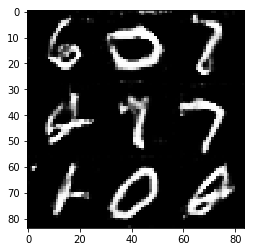

Generator Loss: 0.4836 ........ Discriminator Loss: 1.6235
Generator Loss: 1.1218 ........ Discriminator Loss: 1.1663
Generator Loss: 0.6532 ........ Discriminator Loss: 1.1111
Generator Loss: 0.8995 ........ Discriminator Loss: 0.9675
Generator Loss: 0.8907 ........ Discriminator Loss: 1.0458
Generator Loss: 1.1476 ........ Discriminator Loss: 1.1723
Generator Loss: 1.2474 ........ Discriminator Loss: 1.0009
Generator Loss: 1.5396 ........ Discriminator Loss: 0.8798
Generator Loss: 0.7979 ........ Discriminator Loss: 1.5807
Generator Loss: 1.0038 ........ Discriminator Loss: 1.2354


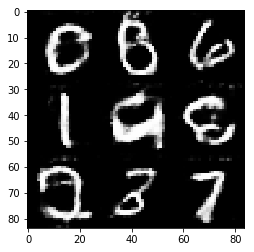

Generator Loss: 0.6557 ........ Discriminator Loss: 1.4275
Generator Loss: 0.7105 ........ Discriminator Loss: 1.1460
Generator Loss: 0.5137 ........ Discriminator Loss: 1.5861
Generator Loss: 1.2973 ........ Discriminator Loss: 0.9838
Generator Loss: 0.5752 ........ Discriminator Loss: 1.2984
Generator Loss: 0.7926 ........ Discriminator Loss: 1.2515
Generator Loss: 0.8729 ........ Discriminator Loss: 1.0478
Generator Loss: 0.9568 ........ Discriminator Loss: 1.0118
Generator Loss: 0.8095 ........ Discriminator Loss: 0.9541
Generator Loss: 0.6853 ........ Discriminator Loss: 1.1495


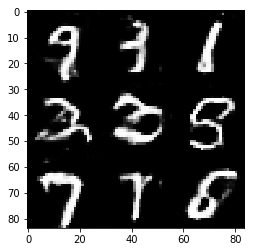

Generator Loss: 0.7866 ........ Discriminator Loss: 1.5213
Generator Loss: 0.7191 ........ Discriminator Loss: 1.1437
Generator Loss: 1.6878 ........ Discriminator Loss: 1.4874
Generator Loss: 1.1304 ........ Discriminator Loss: 1.2241
Generator Loss: 0.6559 ........ Discriminator Loss: 1.1233
Generator Loss: 1.0660 ........ Discriminator Loss: 1.1149
Generator Loss: 2.0187 ........ Discriminator Loss: 1.0672
Generator Loss: 0.9997 ........ Discriminator Loss: 1.1379
Generator Loss: 0.9647 ........ Discriminator Loss: 1.0466
Generator Loss: 0.6649 ........ Discriminator Loss: 1.2232


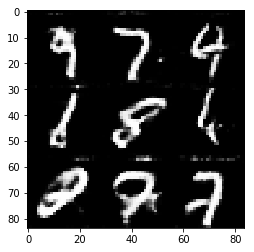

Generator Loss: 0.6800 ........ Discriminator Loss: 1.4157
Generator Loss: 0.6241 ........ Discriminator Loss: 1.4700
Generator Loss: 0.9711 ........ Discriminator Loss: 1.2878
Generator Loss: 0.7833 ........ Discriminator Loss: 1.0627
Generator Loss: 0.8322 ........ Discriminator Loss: 1.3194
Generator Loss: 1.3664 ........ Discriminator Loss: 1.0848
Generator Loss: 0.5629 ........ Discriminator Loss: 1.5296
Generator Loss: 0.7263 ........ Discriminator Loss: 1.3950
Generator Loss: 0.6888 ........ Discriminator Loss: 1.0826
Generator Loss: 0.7874 ........ Discriminator Loss: 0.9989


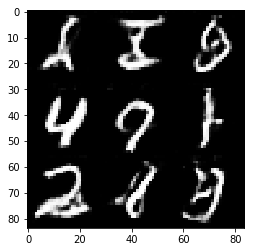

Generator Loss: 0.6175 ........ Discriminator Loss: 1.2509
Generator Loss: 1.5900 ........ Discriminator Loss: 1.0920
Generator Loss: 0.8616 ........ Discriminator Loss: 0.9848
Generator Loss: 1.4672 ........ Discriminator Loss: 0.9735
Generator Loss: 0.7236 ........ Discriminator Loss: 1.9024
Generator Loss: 0.5565 ........ Discriminator Loss: 1.6949
Generator Loss: 1.2900 ........ Discriminator Loss: 0.9515
Generator Loss: 0.8478 ........ Discriminator Loss: 1.2822
Generator Loss: 1.9312 ........ Discriminator Loss: 1.0440
Generator Loss: 0.6809 ........ Discriminator Loss: 1.2449


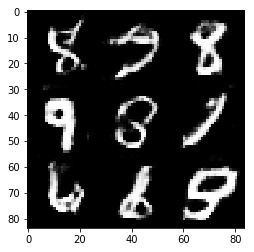

Generator Loss: 0.5640 ........ Discriminator Loss: 1.4765
Generator Loss: 0.7961 ........ Discriminator Loss: 1.0018
Generator Loss: 1.2913 ........ Discriminator Loss: 1.3121
Generator Loss: 1.1212 ........ Discriminator Loss: 1.5589
Generator Loss: 0.7505 ........ Discriminator Loss: 1.2163
Generator Loss: 0.7762 ........ Discriminator Loss: 1.3046
Generator Loss: 0.6390 ........ Discriminator Loss: 1.5708
Generator Loss: 0.9194 ........ Discriminator Loss: 1.0253
Generator Loss: 0.7021 ........ Discriminator Loss: 1.2266
Generator Loss: 0.7610 ........ Discriminator Loss: 1.1927


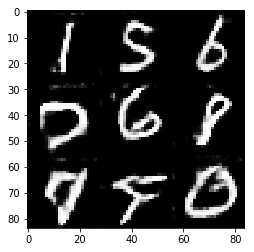

Generator Loss: 0.9181 ........ Discriminator Loss: 1.3208
Generator Loss: 0.8259 ........ Discriminator Loss: 1.3133
Generator Loss: 0.9822 ........ Discriminator Loss: 1.3052
Generator Loss: 0.7752 ........ Discriminator Loss: 1.4777
Generator Loss: 1.4504 ........ Discriminator Loss: 1.3216
Generator Loss: 0.7900 ........ Discriminator Loss: 1.1551
Generator Loss: 0.8661 ........ Discriminator Loss: 1.2638
Generator Loss: 0.6808 ........ Discriminator Loss: 1.3211
Generator Loss: 0.9363 ........ Discriminator Loss: 1.2141
Generator Loss: 0.4676 ........ Discriminator Loss: 1.5958


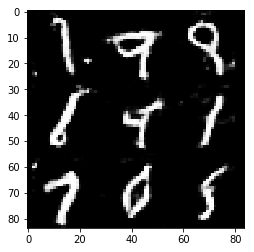

Generator Loss: 0.8075 ........ Discriminator Loss: 1.0012
Generator Loss: 1.0316 ........ Discriminator Loss: 0.9118
Generator Loss: 0.9552 ........ Discriminator Loss: 0.9537
Generator Loss: 1.2890 ........ Discriminator Loss: 0.9273
Generator Loss: 2.1284 ........ Discriminator Loss: 1.2053
Generator Loss: 1.0103 ........ Discriminator Loss: 1.3629
Generator Loss: 0.9777 ........ Discriminator Loss: 1.1368
Generator Loss: 1.1505 ........ Discriminator Loss: 1.2363
Generator Loss: 0.7774 ........ Discriminator Loss: 1.3886
Generator Loss: 1.0583 ........ Discriminator Loss: 1.0565


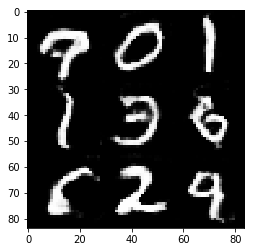

Generator Loss: 1.5101 ........ Discriminator Loss: 0.7780
Generator Loss: 2.4098 ........ Discriminator Loss: 1.4054
Generator Loss: 0.7980 ........ Discriminator Loss: 1.2108
Generator Loss: 1.5206 ........ Discriminator Loss: 0.8995
Generator Loss: 0.9355 ........ Discriminator Loss: 1.3793
Generator Loss: 1.1775 ........ Discriminator Loss: 0.7807
Generator Loss: 0.7013 ........ Discriminator Loss: 1.0979
Generator Loss: 0.8559 ........ Discriminator Loss: 1.0480
Generator Loss: 0.8793 ........ Discriminator Loss: 1.2539
Generator Loss: 1.8042 ........ Discriminator Loss: 0.7762


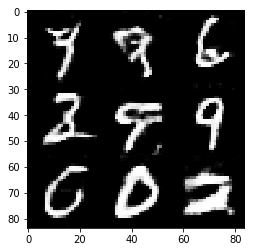

Generator Loss: 1.2767 ........ Discriminator Loss: 1.2637
Generator Loss: 1.2532 ........ Discriminator Loss: 0.8161
Generator Loss: 1.1415 ........ Discriminator Loss: 0.8165
Generator Loss: 0.7284 ........ Discriminator Loss: 0.9592
Generator Loss: 0.5931 ........ Discriminator Loss: 1.5555
Generator Loss: 1.0566 ........ Discriminator Loss: 1.1313
Generator Loss: 0.5067 ........ Discriminator Loss: 1.9108
Generator Loss: 1.3871 ........ Discriminator Loss: 1.3650
Generator Loss: 1.1197 ........ Discriminator Loss: 1.1635
Generator Loss: 1.5959 ........ Discriminator Loss: 0.9275


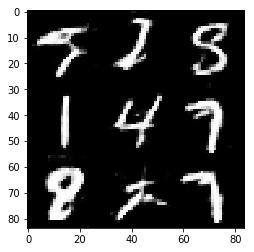

Generator Loss: 0.7011 ........ Discriminator Loss: 1.4639
Generator Loss: 1.0361 ........ Discriminator Loss: 1.1840
Generator Loss: 1.0831 ........ Discriminator Loss: 1.2229
Generator Loss: 0.8634 ........ Discriminator Loss: 1.4334
Generator Loss: 1.3169 ........ Discriminator Loss: 1.0890
Generator Loss: 1.2680 ........ Discriminator Loss: 1.0029
Generator Loss: 1.6252 ........ Discriminator Loss: 0.8237
Generator Loss: 0.7222 ........ Discriminator Loss: 1.4049
Generator Loss: 1.6798 ........ Discriminator Loss: 0.8512
Generator Loss: 1.3495 ........ Discriminator Loss: 0.8660


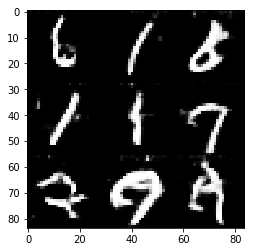

Generator Loss: 1.1673 ........ Discriminator Loss: 0.9647
Generator Loss: 1.2865 ........ Discriminator Loss: 0.9835
Generator Loss: 1.4593 ........ Discriminator Loss: 1.3815
Generator Loss: 0.5665 ........ Discriminator Loss: 1.4580
Generator Loss: 0.9347 ........ Discriminator Loss: 1.2591
Generator Loss: 1.3344 ........ Discriminator Loss: 1.2116
Generator Loss: 1.0874 ........ Discriminator Loss: 1.1336
Generator Loss: 0.7527 ........ Discriminator Loss: 1.1764
Generator Loss: 0.8798 ........ Discriminator Loss: 0.9017
Generator Loss: 0.6479 ........ Discriminator Loss: 1.7173


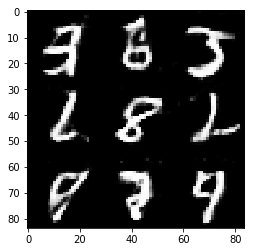

Generator Loss: 1.1935 ........ Discriminator Loss: 1.1926
Generator Loss: 0.9132 ........ Discriminator Loss: 1.2597
Generator Loss: 0.4995 ........ Discriminator Loss: 1.9142
Generator Loss: 1.1437 ........ Discriminator Loss: 1.0477
Generator Loss: 1.0396 ........ Discriminator Loss: 0.9383
Generator Loss: 0.9832 ........ Discriminator Loss: 1.5178
Generator Loss: 1.2632 ........ Discriminator Loss: 1.4256
Generator Loss: 1.0008 ........ Discriminator Loss: 1.0830
Generator Loss: 0.9437 ........ Discriminator Loss: 1.2075
Generator Loss: 1.2726 ........ Discriminator Loss: 1.1370


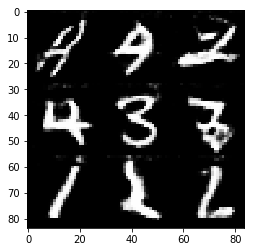

Generator Loss: 0.8954 ........ Discriminator Loss: 1.6566
Generator Loss: 0.8638 ........ Discriminator Loss: 1.1129
Generator Loss: 1.4807 ........ Discriminator Loss: 1.1040
Generator Loss: 1.4546 ........ Discriminator Loss: 1.6935
Generator Loss: 1.1127 ........ Discriminator Loss: 1.4820
Generator Loss: 1.0926 ........ Discriminator Loss: 1.2894
Generator Loss: 1.9625 ........ Discriminator Loss: 0.7923
Generator Loss: 1.7205 ........ Discriminator Loss: 1.0297
Generator Loss: 0.7706 ........ Discriminator Loss: 1.3257
Generator Loss: 0.7606 ........ Discriminator Loss: 1.2685


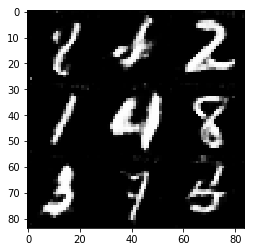

In [18]:
batch_size = 20
z_dim = 128
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Generator Loss: 1.3231 ........ Discriminator Loss: 0.8626
Generator Loss: 2.0597 ........ Discriminator Loss: 0.7397
Generator Loss: 4.2027 ........ Discriminator Loss: 0.6890
Generator Loss: 2.0636 ........ Discriminator Loss: 0.7097
Generator Loss: 4.9269 ........ Discriminator Loss: 0.6774
Generator Loss: 3.5585 ........ Discriminator Loss: 0.6027
Generator Loss: 1.8530 ........ Discriminator Loss: 1.0181
Generator Loss: 2.8217 ........ Discriminator Loss: 0.7486
Generator Loss: 1.6462 ........ Discriminator Loss: 1.1033
Generator Loss: 0.4548 ........ Discriminator Loss: 2.4869


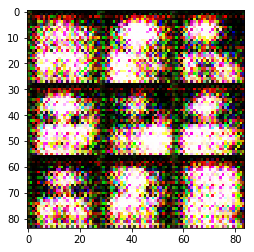

Generator Loss: 0.5646 ........ Discriminator Loss: 1.2825
Generator Loss: 1.4237 ........ Discriminator Loss: 1.0682
Generator Loss: 0.7898 ........ Discriminator Loss: 1.6267
Generator Loss: 0.3004 ........ Discriminator Loss: 1.9210
Generator Loss: 3.8356 ........ Discriminator Loss: 0.9451
Generator Loss: 2.1391 ........ Discriminator Loss: 1.1053
Generator Loss: 0.5133 ........ Discriminator Loss: 1.6385
Generator Loss: 0.7739 ........ Discriminator Loss: 1.7496
Generator Loss: 2.8797 ........ Discriminator Loss: 0.7267
Generator Loss: 1.6351 ........ Discriminator Loss: 0.8527


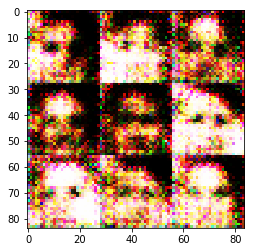

Generator Loss: 2.3837 ........ Discriminator Loss: 0.5839
Generator Loss: 2.2041 ........ Discriminator Loss: 0.7183
Generator Loss: 3.7433 ........ Discriminator Loss: 0.6608
Generator Loss: 0.3747 ........ Discriminator Loss: 1.6540
Generator Loss: 1.1048 ........ Discriminator Loss: 1.4093
Generator Loss: 1.4458 ........ Discriminator Loss: 1.0839
Generator Loss: 3.2039 ........ Discriminator Loss: 0.7602
Generator Loss: 2.4094 ........ Discriminator Loss: 1.0645
Generator Loss: 3.0808 ........ Discriminator Loss: 0.6402
Generator Loss: 2.3353 ........ Discriminator Loss: 1.0754


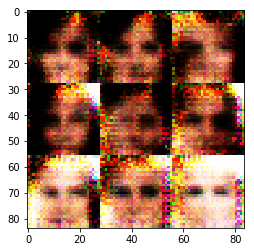

Generator Loss: 3.0052 ........ Discriminator Loss: 0.8444
Generator Loss: 3.0745 ........ Discriminator Loss: 0.9067
Generator Loss: 3.0098 ........ Discriminator Loss: 0.6181
Generator Loss: 0.5279 ........ Discriminator Loss: 1.4897
Generator Loss: 1.1001 ........ Discriminator Loss: 1.2388
Generator Loss: 0.7970 ........ Discriminator Loss: 1.0352
Generator Loss: 2.2929 ........ Discriminator Loss: 0.9920
Generator Loss: 1.8387 ........ Discriminator Loss: 0.6853
Generator Loss: 1.9166 ........ Discriminator Loss: 0.7497
Generator Loss: 1.1243 ........ Discriminator Loss: 1.0771


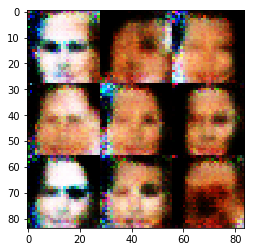

Generator Loss: 2.6675 ........ Discriminator Loss: 0.8962
Generator Loss: 0.7656 ........ Discriminator Loss: 1.3269
Generator Loss: 1.6649 ........ Discriminator Loss: 1.2149
Generator Loss: 2.0957 ........ Discriminator Loss: 0.9621
Generator Loss: 2.1390 ........ Discriminator Loss: 0.9120
Generator Loss: 2.8362 ........ Discriminator Loss: 0.7604
Generator Loss: 1.6776 ........ Discriminator Loss: 0.9781
Generator Loss: 1.7694 ........ Discriminator Loss: 0.8720
Generator Loss: 0.9410 ........ Discriminator Loss: 1.3583
Generator Loss: 0.5625 ........ Discriminator Loss: 1.7650


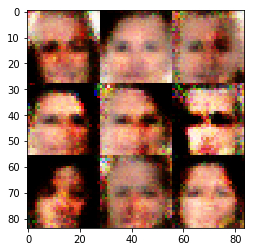

Generator Loss: 2.1464 ........ Discriminator Loss: 1.3150
Generator Loss: 3.8286 ........ Discriminator Loss: 0.6056
Generator Loss: 0.6273 ........ Discriminator Loss: 1.5676
Generator Loss: 1.1949 ........ Discriminator Loss: 0.9150
Generator Loss: 1.1653 ........ Discriminator Loss: 1.4623
Generator Loss: 0.8835 ........ Discriminator Loss: 1.3074
Generator Loss: 1.9617 ........ Discriminator Loss: 1.1771
Generator Loss: 2.9117 ........ Discriminator Loss: 1.3218
Generator Loss: 0.3938 ........ Discriminator Loss: 2.1707
Generator Loss: 0.7746 ........ Discriminator Loss: 1.1559


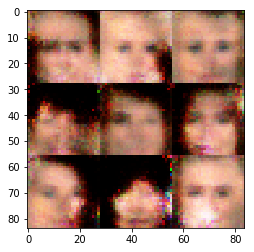

Generator Loss: 2.4738 ........ Discriminator Loss: 1.0175
Generator Loss: 1.2442 ........ Discriminator Loss: 0.9786
Generator Loss: 3.2555 ........ Discriminator Loss: 1.1296
Generator Loss: 2.1222 ........ Discriminator Loss: 1.5886
Generator Loss: 1.4481 ........ Discriminator Loss: 0.7749
Generator Loss: 0.7907 ........ Discriminator Loss: 1.0698
Generator Loss: 1.2200 ........ Discriminator Loss: 1.6926
Generator Loss: 2.3072 ........ Discriminator Loss: 0.8108
Generator Loss: 0.6891 ........ Discriminator Loss: 1.7849
Generator Loss: 1.7316 ........ Discriminator Loss: 0.7350


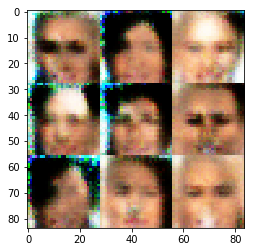

Generator Loss: 0.8225 ........ Discriminator Loss: 1.1354
Generator Loss: 0.5291 ........ Discriminator Loss: 1.6622
Generator Loss: 0.7317 ........ Discriminator Loss: 1.2615
Generator Loss: 1.7998 ........ Discriminator Loss: 0.8322
Generator Loss: 1.4276 ........ Discriminator Loss: 1.1053
Generator Loss: 1.3082 ........ Discriminator Loss: 1.2619
Generator Loss: 1.2947 ........ Discriminator Loss: 1.3033
Generator Loss: 1.0604 ........ Discriminator Loss: 0.9022
Generator Loss: 0.6397 ........ Discriminator Loss: 1.5860
Generator Loss: 1.0765 ........ Discriminator Loss: 1.0097


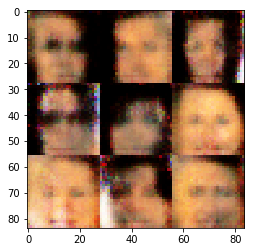

Generator Loss: 0.9910 ........ Discriminator Loss: 1.1903
Generator Loss: 1.4563 ........ Discriminator Loss: 0.8212
Generator Loss: 0.9670 ........ Discriminator Loss: 1.5533
Generator Loss: 2.1990 ........ Discriminator Loss: 0.8409
Generator Loss: 0.7981 ........ Discriminator Loss: 1.7326
Generator Loss: 0.4915 ........ Discriminator Loss: 1.6771
Generator Loss: 1.0527 ........ Discriminator Loss: 1.0494
Generator Loss: 1.7266 ........ Discriminator Loss: 0.9358
Generator Loss: 0.6107 ........ Discriminator Loss: 1.5196
Generator Loss: 1.5142 ........ Discriminator Loss: 1.3511


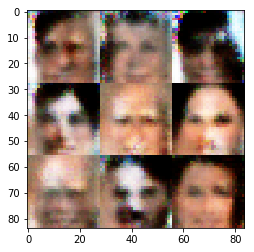

Generator Loss: 0.5163 ........ Discriminator Loss: 1.6165
Generator Loss: 2.0567 ........ Discriminator Loss: 2.2309
Generator Loss: 0.5739 ........ Discriminator Loss: 1.4061
Generator Loss: 1.7395 ........ Discriminator Loss: 0.7335
Generator Loss: 1.7514 ........ Discriminator Loss: 0.9883
Generator Loss: 1.4128 ........ Discriminator Loss: 1.2059
Generator Loss: 0.7007 ........ Discriminator Loss: 1.1249
Generator Loss: 0.8608 ........ Discriminator Loss: 1.4055
Generator Loss: 3.8399 ........ Discriminator Loss: 1.5181
Generator Loss: 1.3405 ........ Discriminator Loss: 0.9425


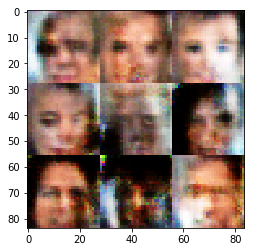

Generator Loss: 1.2388 ........ Discriminator Loss: 1.1764
Generator Loss: 0.4863 ........ Discriminator Loss: 1.2882
Generator Loss: 1.1831 ........ Discriminator Loss: 1.4497
Generator Loss: 0.4668 ........ Discriminator Loss: 1.8733
Generator Loss: 1.0820 ........ Discriminator Loss: 1.4108
Generator Loss: 2.7057 ........ Discriminator Loss: 0.9176
Generator Loss: 0.8611 ........ Discriminator Loss: 1.2782
Generator Loss: 0.9987 ........ Discriminator Loss: 1.2168
Generator Loss: 1.5642 ........ Discriminator Loss: 1.5670
Generator Loss: 2.2204 ........ Discriminator Loss: 1.2740


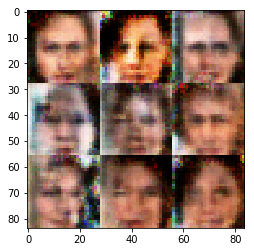

Generator Loss: 1.5128 ........ Discriminator Loss: 1.1463
Generator Loss: 1.6643 ........ Discriminator Loss: 1.0994
Generator Loss: 1.0278 ........ Discriminator Loss: 1.1781
Generator Loss: 0.4682 ........ Discriminator Loss: 1.5880
Generator Loss: 1.0248 ........ Discriminator Loss: 1.1512
Generator Loss: 0.3952 ........ Discriminator Loss: 2.0577
Generator Loss: 1.8066 ........ Discriminator Loss: 1.7386
Generator Loss: 1.9760 ........ Discriminator Loss: 1.4000
Generator Loss: 0.6198 ........ Discriminator Loss: 1.4106
Generator Loss: 0.7938 ........ Discriminator Loss: 1.3372


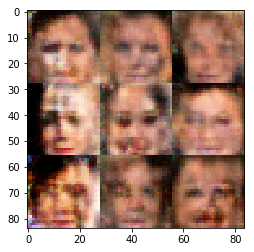

Generator Loss: 0.8755 ........ Discriminator Loss: 1.4280
Generator Loss: 1.9876 ........ Discriminator Loss: 1.0910
Generator Loss: 1.2771 ........ Discriminator Loss: 1.4465
Generator Loss: 1.9233 ........ Discriminator Loss: 1.4359
Generator Loss: 0.7662 ........ Discriminator Loss: 1.4499
Generator Loss: 1.1590 ........ Discriminator Loss: 1.4437
Generator Loss: 0.4922 ........ Discriminator Loss: 1.9292
Generator Loss: 1.2133 ........ Discriminator Loss: 1.2781
Generator Loss: 1.3821 ........ Discriminator Loss: 1.1696
Generator Loss: 1.0382 ........ Discriminator Loss: 1.0936


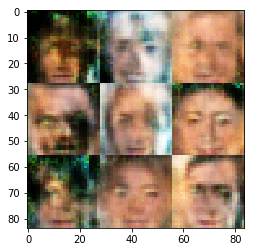

Generator Loss: 0.5257 ........ Discriminator Loss: 1.4760
Generator Loss: 1.0521 ........ Discriminator Loss: 1.5867
Generator Loss: 1.0881 ........ Discriminator Loss: 1.5305
Generator Loss: 1.5947 ........ Discriminator Loss: 1.9867
Generator Loss: 0.5960 ........ Discriminator Loss: 1.5908
Generator Loss: 0.7030 ........ Discriminator Loss: 1.4043
Generator Loss: 0.6906 ........ Discriminator Loss: 1.2109
Generator Loss: 0.9940 ........ Discriminator Loss: 1.2526
Generator Loss: 1.6272 ........ Discriminator Loss: 1.6162
Generator Loss: 0.9647 ........ Discriminator Loss: 1.3937


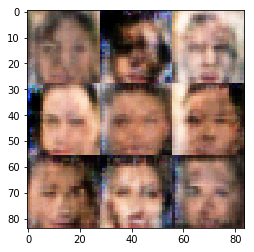

Generator Loss: 1.0185 ........ Discriminator Loss: 1.2427
Generator Loss: 1.0203 ........ Discriminator Loss: 1.4504
Generator Loss: 0.4430 ........ Discriminator Loss: 1.9134
Generator Loss: 0.6643 ........ Discriminator Loss: 1.3744
Generator Loss: 1.7654 ........ Discriminator Loss: 1.9821
Generator Loss: 0.9694 ........ Discriminator Loss: 1.7339
Generator Loss: 0.8012 ........ Discriminator Loss: 1.1864
Generator Loss: 0.7963 ........ Discriminator Loss: 1.3057
Generator Loss: 0.7665 ........ Discriminator Loss: 1.4041
Generator Loss: 0.4269 ........ Discriminator Loss: 1.8687


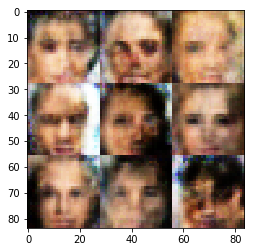

Generator Loss: 1.2977 ........ Discriminator Loss: 1.8584
Generator Loss: 1.8183 ........ Discriminator Loss: 1.1861
Generator Loss: 0.6977 ........ Discriminator Loss: 1.3248
Generator Loss: 0.3670 ........ Discriminator Loss: 2.2093
Generator Loss: 1.0991 ........ Discriminator Loss: 1.4369
Generator Loss: 0.7327 ........ Discriminator Loss: 1.2703
Generator Loss: 0.6922 ........ Discriminator Loss: 1.2284
Generator Loss: 0.6818 ........ Discriminator Loss: 1.4266
Generator Loss: 0.7410 ........ Discriminator Loss: 1.8403
Generator Loss: 0.4920 ........ Discriminator Loss: 1.8887


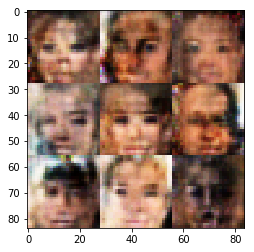

Generator Loss: 0.9500 ........ Discriminator Loss: 1.3997
Generator Loss: 1.2931 ........ Discriminator Loss: 1.6983
Generator Loss: 0.8435 ........ Discriminator Loss: 1.4273
Generator Loss: 1.1350 ........ Discriminator Loss: 1.2194
Generator Loss: 0.5599 ........ Discriminator Loss: 1.5079
Generator Loss: 0.8506 ........ Discriminator Loss: 1.4242
Generator Loss: 0.9555 ........ Discriminator Loss: 1.2238
Generator Loss: 1.0978 ........ Discriminator Loss: 1.5616
Generator Loss: 1.2076 ........ Discriminator Loss: 1.5149
Generator Loss: 0.7316 ........ Discriminator Loss: 1.6594


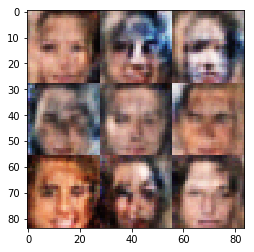

Generator Loss: 0.8209 ........ Discriminator Loss: 1.5151
Generator Loss: 0.4887 ........ Discriminator Loss: 1.6029
Generator Loss: 0.6017 ........ Discriminator Loss: 1.4424
Generator Loss: 1.0526 ........ Discriminator Loss: 1.4085
Generator Loss: 0.5052 ........ Discriminator Loss: 1.3379
Generator Loss: 0.4808 ........ Discriminator Loss: 1.5338
Generator Loss: 0.7100 ........ Discriminator Loss: 1.6393
Generator Loss: 0.5981 ........ Discriminator Loss: 1.6037
Generator Loss: 0.7625 ........ Discriminator Loss: 1.4663
Generator Loss: 0.9366 ........ Discriminator Loss: 1.2826


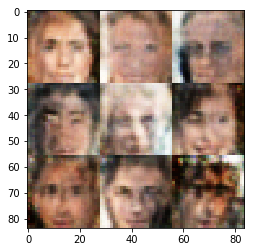

Generator Loss: 0.5444 ........ Discriminator Loss: 1.4554
Generator Loss: 0.9029 ........ Discriminator Loss: 1.3347
Generator Loss: 0.5488 ........ Discriminator Loss: 1.6629
Generator Loss: 0.8188 ........ Discriminator Loss: 1.6452
Generator Loss: 0.6270 ........ Discriminator Loss: 1.6638
Generator Loss: 0.5236 ........ Discriminator Loss: 1.8503
Generator Loss: 0.4358 ........ Discriminator Loss: 1.8076
Generator Loss: 0.6484 ........ Discriminator Loss: 1.4751
Generator Loss: 0.7095 ........ Discriminator Loss: 1.6722
Generator Loss: 0.9183 ........ Discriminator Loss: 1.2677


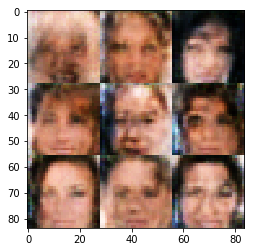

Generator Loss: 0.6003 ........ Discriminator Loss: 1.4041
Generator Loss: 0.8394 ........ Discriminator Loss: 1.4201
Generator Loss: 0.7309 ........ Discriminator Loss: 1.3305
Generator Loss: 0.5193 ........ Discriminator Loss: 1.2539
Generator Loss: 1.0933 ........ Discriminator Loss: 1.1168
Generator Loss: 0.6092 ........ Discriminator Loss: 1.2803
Generator Loss: 0.4846 ........ Discriminator Loss: 1.6562
Generator Loss: 1.5624 ........ Discriminator Loss: 1.1606
Generator Loss: 0.6963 ........ Discriminator Loss: 1.6155
Generator Loss: 0.9382 ........ Discriminator Loss: 1.3534


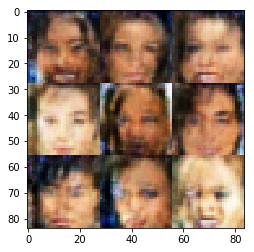

Generator Loss: 0.4266 ........ Discriminator Loss: 1.6567
Generator Loss: 0.5381 ........ Discriminator Loss: 1.6342
Generator Loss: 0.4158 ........ Discriminator Loss: 1.5895
Generator Loss: 0.5929 ........ Discriminator Loss: 1.5423
Generator Loss: 0.9359 ........ Discriminator Loss: 1.1697
Generator Loss: 0.8061 ........ Discriminator Loss: 1.3758
Generator Loss: 0.9927 ........ Discriminator Loss: 1.4374
Generator Loss: 1.0109 ........ Discriminator Loss: 1.0835
Generator Loss: 0.6138 ........ Discriminator Loss: 1.5927
Generator Loss: 0.4865 ........ Discriminator Loss: 1.5548


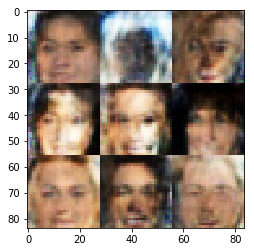

Generator Loss: 0.6551 ........ Discriminator Loss: 1.6812
Generator Loss: 0.4150 ........ Discriminator Loss: 1.6329
Generator Loss: 0.9847 ........ Discriminator Loss: 1.0814
Generator Loss: 1.0344 ........ Discriminator Loss: 1.5651
Generator Loss: 0.6799 ........ Discriminator Loss: 1.3469
Generator Loss: 0.8999 ........ Discriminator Loss: 1.4068
Generator Loss: 0.8329 ........ Discriminator Loss: 1.4794
Generator Loss: 1.1349 ........ Discriminator Loss: 1.5561
Generator Loss: 0.7630 ........ Discriminator Loss: 1.3576
Generator Loss: 0.7608 ........ Discriminator Loss: 1.3568


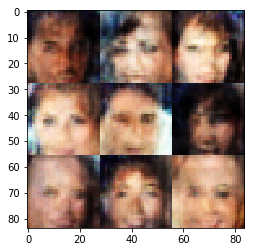

Generator Loss: 1.0285 ........ Discriminator Loss: 1.0553
Generator Loss: 0.8648 ........ Discriminator Loss: 1.4849
Generator Loss: 0.9598 ........ Discriminator Loss: 1.2663
Generator Loss: 0.7406 ........ Discriminator Loss: 1.4818
Generator Loss: 0.6571 ........ Discriminator Loss: 1.5374
Generator Loss: 0.7309 ........ Discriminator Loss: 1.6331
Generator Loss: 0.5540 ........ Discriminator Loss: 1.6679
Generator Loss: 0.6520 ........ Discriminator Loss: 1.3379
Generator Loss: 0.7466 ........ Discriminator Loss: 1.2566
Generator Loss: 0.5982 ........ Discriminator Loss: 1.4514


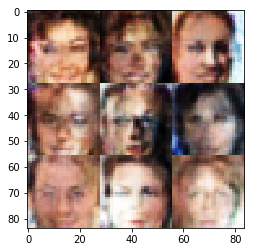

Generator Loss: 0.8285 ........ Discriminator Loss: 1.5365
Generator Loss: 0.8082 ........ Discriminator Loss: 1.4720
Generator Loss: 0.6642 ........ Discriminator Loss: 1.3819
Generator Loss: 0.7048 ........ Discriminator Loss: 1.3859
Generator Loss: 0.7076 ........ Discriminator Loss: 1.1517
Generator Loss: 0.7800 ........ Discriminator Loss: 1.0909
Generator Loss: 0.6963 ........ Discriminator Loss: 1.3874
Generator Loss: 0.7144 ........ Discriminator Loss: 1.4311
Generator Loss: 0.9453 ........ Discriminator Loss: 1.2700
Generator Loss: 0.8841 ........ Discriminator Loss: 1.2823


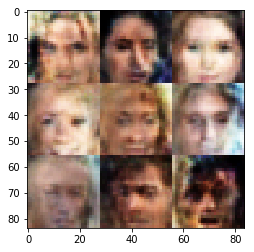

Generator Loss: 0.5378 ........ Discriminator Loss: 1.3566
Generator Loss: 0.7213 ........ Discriminator Loss: 1.4395
Generator Loss: 0.7450 ........ Discriminator Loss: 1.3406
Generator Loss: 1.1180 ........ Discriminator Loss: 1.2791
Generator Loss: 0.6320 ........ Discriminator Loss: 1.5527
Generator Loss: 0.6951 ........ Discriminator Loss: 1.3054
Generator Loss: 0.7589 ........ Discriminator Loss: 1.3972
Generator Loss: 0.4060 ........ Discriminator Loss: 1.7235
Generator Loss: 0.8707 ........ Discriminator Loss: 1.2774
Generator Loss: 1.4700 ........ Discriminator Loss: 1.0187


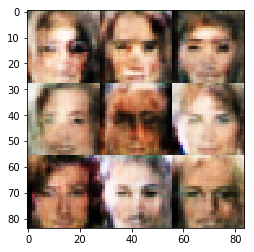

Generator Loss: 1.0803 ........ Discriminator Loss: 1.1037
Generator Loss: 1.2527 ........ Discriminator Loss: 1.1595
Generator Loss: 0.5765 ........ Discriminator Loss: 1.2809
Generator Loss: 0.7227 ........ Discriminator Loss: 1.2518
Generator Loss: 0.6556 ........ Discriminator Loss: 1.4122
Generator Loss: 0.5043 ........ Discriminator Loss: 1.5977
Generator Loss: 1.5044 ........ Discriminator Loss: 1.3592
Generator Loss: 0.5796 ........ Discriminator Loss: 1.5136
Generator Loss: 0.6049 ........ Discriminator Loss: 1.6429
Generator Loss: 0.5079 ........ Discriminator Loss: 1.6734


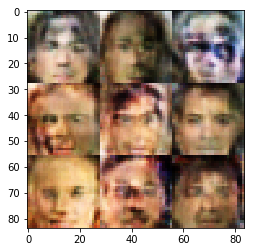

Generator Loss: 0.5174 ........ Discriminator Loss: 1.5497
Generator Loss: 0.6264 ........ Discriminator Loss: 1.3067
Generator Loss: 1.4707 ........ Discriminator Loss: 1.2085
Generator Loss: 0.4723 ........ Discriminator Loss: 1.6697
Generator Loss: 1.0873 ........ Discriminator Loss: 1.5489
Generator Loss: 0.9291 ........ Discriminator Loss: 1.4879
Generator Loss: 0.6139 ........ Discriminator Loss: 1.6472
Generator Loss: 0.6026 ........ Discriminator Loss: 1.2656
Generator Loss: 0.7626 ........ Discriminator Loss: 1.2166
Generator Loss: 0.8267 ........ Discriminator Loss: 1.2706


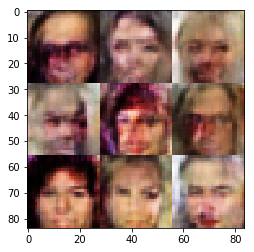

Generator Loss: 0.4253 ........ Discriminator Loss: 1.5485
Generator Loss: 0.6444 ........ Discriminator Loss: 1.6627
Generator Loss: 0.8789 ........ Discriminator Loss: 1.4713
Generator Loss: 0.7750 ........ Discriminator Loss: 1.6498
Generator Loss: 1.0429 ........ Discriminator Loss: 1.4522
Generator Loss: 0.9768 ........ Discriminator Loss: 1.5287
Generator Loss: 0.6678 ........ Discriminator Loss: 1.5003
Generator Loss: 0.9000 ........ Discriminator Loss: 1.2752
Generator Loss: 0.7625 ........ Discriminator Loss: 1.5984
Generator Loss: 0.6874 ........ Discriminator Loss: 1.3772


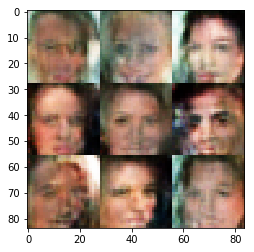

Generator Loss: 0.5825 ........ Discriminator Loss: 1.3879
Generator Loss: 0.4507 ........ Discriminator Loss: 1.6904
Generator Loss: 0.8841 ........ Discriminator Loss: 1.2873
Generator Loss: 1.0251 ........ Discriminator Loss: 1.3769
Generator Loss: 0.7682 ........ Discriminator Loss: 1.6431
Generator Loss: 0.9181 ........ Discriminator Loss: 1.3423
Generator Loss: 0.4643 ........ Discriminator Loss: 1.6244
Generator Loss: 0.7109 ........ Discriminator Loss: 1.4684
Generator Loss: 0.6921 ........ Discriminator Loss: 1.3291
Generator Loss: 0.5569 ........ Discriminator Loss: 1.7937


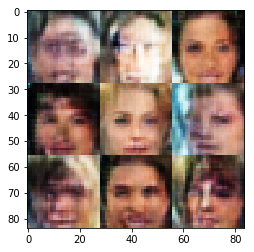

Generator Loss: 0.8749 ........ Discriminator Loss: 1.3807
Generator Loss: 0.8954 ........ Discriminator Loss: 1.1746
Generator Loss: 0.8638 ........ Discriminator Loss: 1.6075
Generator Loss: 1.1839 ........ Discriminator Loss: 1.2957
Generator Loss: 0.8299 ........ Discriminator Loss: 1.1914
Generator Loss: 0.6567 ........ Discriminator Loss: 1.4654
Generator Loss: 0.5417 ........ Discriminator Loss: 1.5413
Generator Loss: 0.6207 ........ Discriminator Loss: 1.5561
Generator Loss: 0.4984 ........ Discriminator Loss: 1.6845
Generator Loss: 0.4616 ........ Discriminator Loss: 1.5274


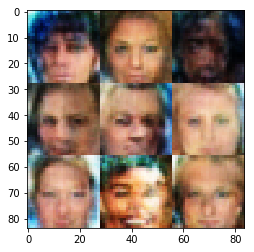

Generator Loss: 0.4866 ........ Discriminator Loss: 1.5079
Generator Loss: 0.7387 ........ Discriminator Loss: 1.4941
Generator Loss: 0.5516 ........ Discriminator Loss: 1.4122
Generator Loss: 0.5173 ........ Discriminator Loss: 1.7227
Generator Loss: 0.8358 ........ Discriminator Loss: 1.5751
Generator Loss: 0.8784 ........ Discriminator Loss: 1.4133
Generator Loss: 0.7548 ........ Discriminator Loss: 1.4189
Generator Loss: 0.7255 ........ Discriminator Loss: 1.4345
Generator Loss: 0.4563 ........ Discriminator Loss: 1.7266
Generator Loss: 0.8293 ........ Discriminator Loss: 1.1201


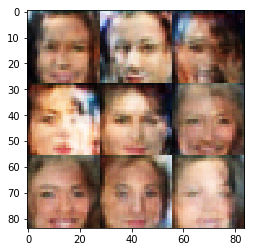

Generator Loss: 1.0299 ........ Discriminator Loss: 1.3056
Generator Loss: 0.5781 ........ Discriminator Loss: 1.4203
Generator Loss: 0.5862 ........ Discriminator Loss: 1.4168
Generator Loss: 0.6831 ........ Discriminator Loss: 1.3768
Generator Loss: 0.7499 ........ Discriminator Loss: 1.3371
Generator Loss: 0.7052 ........ Discriminator Loss: 1.3708
Generator Loss: 0.6797 ........ Discriminator Loss: 1.4462
Generator Loss: 0.7526 ........ Discriminator Loss: 1.3305
Generator Loss: 0.7445 ........ Discriminator Loss: 1.5169
Generator Loss: 0.5330 ........ Discriminator Loss: 1.7810


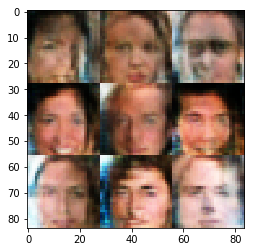

Generator Loss: 0.5508 ........ Discriminator Loss: 1.5806
Generator Loss: 0.8157 ........ Discriminator Loss: 1.3285
Generator Loss: 0.7986 ........ Discriminator Loss: 1.4328
Generator Loss: 0.8232 ........ Discriminator Loss: 1.1903
Generator Loss: 0.4348 ........ Discriminator Loss: 1.3808
Generator Loss: 0.9829 ........ Discriminator Loss: 1.4389
Generator Loss: 0.6396 ........ Discriminator Loss: 1.2888
Generator Loss: 0.5330 ........ Discriminator Loss: 1.2734
Generator Loss: 0.6210 ........ Discriminator Loss: 1.4451
Generator Loss: 0.5041 ........ Discriminator Loss: 1.7417


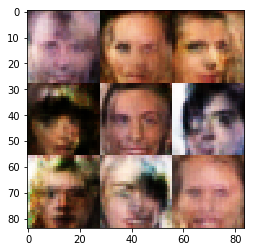

Generator Loss: 0.6425 ........ Discriminator Loss: 1.3190
Generator Loss: 0.7011 ........ Discriminator Loss: 1.6830
Generator Loss: 0.7618 ........ Discriminator Loss: 1.3363
Generator Loss: 1.1077 ........ Discriminator Loss: 1.4652
Generator Loss: 0.9422 ........ Discriminator Loss: 1.2589
Generator Loss: 0.4032 ........ Discriminator Loss: 1.9235
Generator Loss: 0.9225 ........ Discriminator Loss: 1.3562
Generator Loss: 0.5645 ........ Discriminator Loss: 1.4690
Generator Loss: 0.6936 ........ Discriminator Loss: 1.6229
Generator Loss: 0.5826 ........ Discriminator Loss: 1.6000


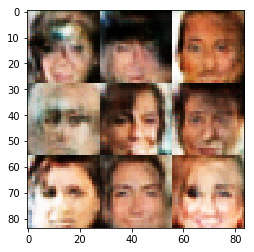

Generator Loss: 0.5002 ........ Discriminator Loss: 1.4367
Generator Loss: 0.5895 ........ Discriminator Loss: 1.4464
Generator Loss: 0.8351 ........ Discriminator Loss: 1.4046
Generator Loss: 0.5439 ........ Discriminator Loss: 1.2326
Generator Loss: 0.5431 ........ Discriminator Loss: 1.4640
Generator Loss: 0.4786 ........ Discriminator Loss: 1.7842
Generator Loss: 0.7100 ........ Discriminator Loss: 1.4251
Generator Loss: 0.7935 ........ Discriminator Loss: 1.1064
Generator Loss: 0.6234 ........ Discriminator Loss: 1.4547
Generator Loss: 0.4865 ........ Discriminator Loss: 1.3789


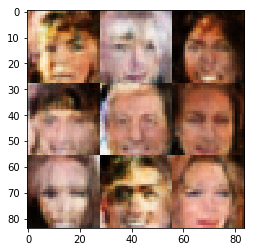

Generator Loss: 0.9179 ........ Discriminator Loss: 1.3673
Generator Loss: 0.6802 ........ Discriminator Loss: 1.5190
Generator Loss: 0.7670 ........ Discriminator Loss: 1.4765
Generator Loss: 0.5203 ........ Discriminator Loss: 1.4195
Generator Loss: 0.4451 ........ Discriminator Loss: 1.3758
Generator Loss: 0.6915 ........ Discriminator Loss: 1.4808
Generator Loss: 0.7615 ........ Discriminator Loss: 1.3519
Generator Loss: 0.7045 ........ Discriminator Loss: 1.5070
Generator Loss: 0.5962 ........ Discriminator Loss: 1.4061
Generator Loss: 0.9402 ........ Discriminator Loss: 1.2818


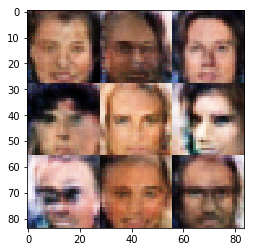

Generator Loss: 0.5250 ........ Discriminator Loss: 1.7986
Generator Loss: 0.5089 ........ Discriminator Loss: 1.7637
Generator Loss: 0.8283 ........ Discriminator Loss: 1.3348
Generator Loss: 0.4836 ........ Discriminator Loss: 1.8827
Generator Loss: 0.6473 ........ Discriminator Loss: 1.5622
Generator Loss: 0.5954 ........ Discriminator Loss: 1.4407
Generator Loss: 0.7192 ........ Discriminator Loss: 1.1853
Generator Loss: 0.7112 ........ Discriminator Loss: 1.4387
Generator Loss: 0.4660 ........ Discriminator Loss: 1.4993
Generator Loss: 0.7186 ........ Discriminator Loss: 1.6869


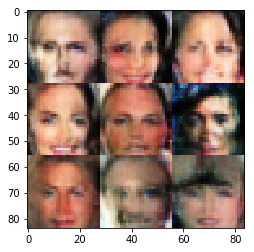

Generator Loss: 0.5616 ........ Discriminator Loss: 1.2586
Generator Loss: 0.6290 ........ Discriminator Loss: 1.4926
Generator Loss: 0.6053 ........ Discriminator Loss: 1.6814
Generator Loss: 1.1370 ........ Discriminator Loss: 1.6001
Generator Loss: 0.5899 ........ Discriminator Loss: 1.6516
Generator Loss: 0.5849 ........ Discriminator Loss: 1.4494
Generator Loss: 0.4422 ........ Discriminator Loss: 1.8772
Generator Loss: 0.7671 ........ Discriminator Loss: 1.4817
Generator Loss: 0.6992 ........ Discriminator Loss: 1.4285
Generator Loss: 0.5261 ........ Discriminator Loss: 1.5936


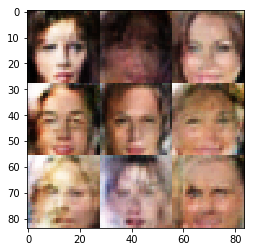

Generator Loss: 0.9234 ........ Discriminator Loss: 1.3253
Generator Loss: 0.7646 ........ Discriminator Loss: 1.2275
Generator Loss: 0.6878 ........ Discriminator Loss: 1.2495
Generator Loss: 0.7245 ........ Discriminator Loss: 1.3720
Generator Loss: 0.6579 ........ Discriminator Loss: 1.4514
Generator Loss: 0.9298 ........ Discriminator Loss: 1.2818
Generator Loss: 0.9961 ........ Discriminator Loss: 1.5184
Generator Loss: 0.6176 ........ Discriminator Loss: 1.5203
Generator Loss: 0.6239 ........ Discriminator Loss: 1.4153
Generator Loss: 0.8558 ........ Discriminator Loss: 1.4615


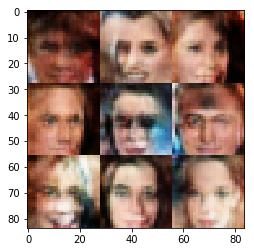

Generator Loss: 0.5227 ........ Discriminator Loss: 1.5922
Generator Loss: 0.4412 ........ Discriminator Loss: 1.5854
Generator Loss: 1.0896 ........ Discriminator Loss: 1.5350
Generator Loss: 0.8269 ........ Discriminator Loss: 1.3757
Generator Loss: 0.8761 ........ Discriminator Loss: 1.4623
Generator Loss: 1.0165 ........ Discriminator Loss: 1.0127
Generator Loss: 0.6467 ........ Discriminator Loss: 1.5379
Generator Loss: 0.7471 ........ Discriminator Loss: 1.5227
Generator Loss: 0.5525 ........ Discriminator Loss: 1.6064
Generator Loss: 0.7857 ........ Discriminator Loss: 1.1971


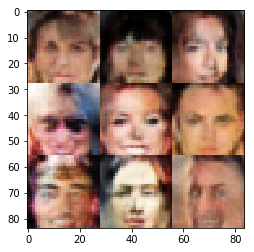

Generator Loss: 1.0961 ........ Discriminator Loss: 1.4976
Generator Loss: 0.7942 ........ Discriminator Loss: 1.4638
Generator Loss: 0.5668 ........ Discriminator Loss: 1.4265
Generator Loss: 0.6743 ........ Discriminator Loss: 1.4986
Generator Loss: 0.5276 ........ Discriminator Loss: 1.8274
Generator Loss: 0.6667 ........ Discriminator Loss: 1.2706
Generator Loss: 0.5253 ........ Discriminator Loss: 1.5267
Generator Loss: 0.8302 ........ Discriminator Loss: 1.3111
Generator Loss: 0.7396 ........ Discriminator Loss: 1.4047
Generator Loss: 0.7792 ........ Discriminator Loss: 1.2462


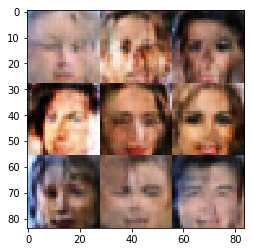

Generator Loss: 0.9275 ........ Discriminator Loss: 1.3730
Generator Loss: 0.8907 ........ Discriminator Loss: 1.2618
Generator Loss: 0.4555 ........ Discriminator Loss: 1.5758
Generator Loss: 0.7847 ........ Discriminator Loss: 1.1630
Generator Loss: 0.7203 ........ Discriminator Loss: 1.3394
Generator Loss: 0.4150 ........ Discriminator Loss: 1.5654
Generator Loss: 0.8061 ........ Discriminator Loss: 1.3144
Generator Loss: 0.6697 ........ Discriminator Loss: 1.7145
Generator Loss: 0.7678 ........ Discriminator Loss: 1.1539
Generator Loss: 0.9795 ........ Discriminator Loss: 1.2458


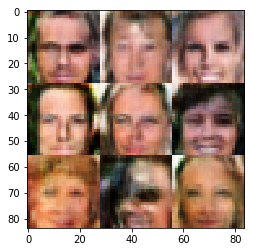

Generator Loss: 0.7335 ........ Discriminator Loss: 1.4169
Generator Loss: 0.8207 ........ Discriminator Loss: 1.4617
Generator Loss: 0.6394 ........ Discriminator Loss: 1.5031
Generator Loss: 0.8456 ........ Discriminator Loss: 1.6878
Generator Loss: 0.6014 ........ Discriminator Loss: 1.4882
Generator Loss: 0.6401 ........ Discriminator Loss: 1.3641
Generator Loss: 0.6228 ........ Discriminator Loss: 1.5803
Generator Loss: 0.7520 ........ Discriminator Loss: 1.1918
Generator Loss: 0.7493 ........ Discriminator Loss: 1.2972
Generator Loss: 0.5370 ........ Discriminator Loss: 1.5582


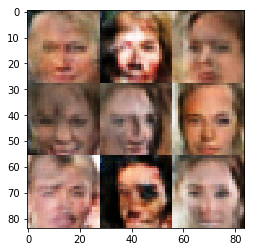

Generator Loss: 0.6623 ........ Discriminator Loss: 1.4319
Generator Loss: 0.4039 ........ Discriminator Loss: 1.4489
Generator Loss: 0.4898 ........ Discriminator Loss: 1.5475
Generator Loss: 0.6353 ........ Discriminator Loss: 1.6114
Generator Loss: 0.5918 ........ Discriminator Loss: 1.4415
Generator Loss: 0.5864 ........ Discriminator Loss: 1.2955
Generator Loss: 0.8588 ........ Discriminator Loss: 1.4422
Generator Loss: 0.8571 ........ Discriminator Loss: 1.3690
Generator Loss: 1.3553 ........ Discriminator Loss: 1.2334
Generator Loss: 0.8172 ........ Discriminator Loss: 1.2624


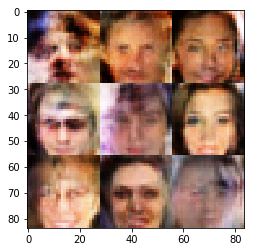

Generator Loss: 0.6853 ........ Discriminator Loss: 1.5756
Generator Loss: 0.5937 ........ Discriminator Loss: 1.6561
Generator Loss: 0.9984 ........ Discriminator Loss: 1.4774
Generator Loss: 0.8327 ........ Discriminator Loss: 1.4673
Generator Loss: 0.7817 ........ Discriminator Loss: 1.2685
Generator Loss: 0.8543 ........ Discriminator Loss: 1.3849
Generator Loss: 0.7088 ........ Discriminator Loss: 1.3072
Generator Loss: 0.5806 ........ Discriminator Loss: 1.5278
Generator Loss: 0.8459 ........ Discriminator Loss: 1.1355
Generator Loss: 0.7368 ........ Discriminator Loss: 1.4318


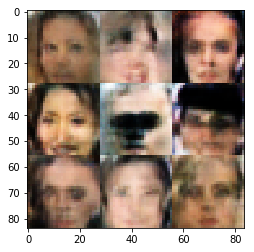

Generator Loss: 1.0733 ........ Discriminator Loss: 1.4678
Generator Loss: 0.5666 ........ Discriminator Loss: 1.3114
Generator Loss: 0.8460 ........ Discriminator Loss: 1.3763
Generator Loss: 0.7458 ........ Discriminator Loss: 1.4296
Generator Loss: 0.6485 ........ Discriminator Loss: 1.2761
Generator Loss: 0.5494 ........ Discriminator Loss: 1.2589
Generator Loss: 0.6738 ........ Discriminator Loss: 1.3029
Generator Loss: 0.5541 ........ Discriminator Loss: 1.4419
Generator Loss: 0.7292 ........ Discriminator Loss: 1.3143
Generator Loss: 0.6329 ........ Discriminator Loss: 1.4600


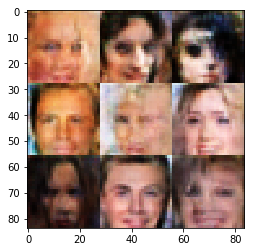

Generator Loss: 0.7998 ........ Discriminator Loss: 1.7405
Generator Loss: 1.1973 ........ Discriminator Loss: 1.2637
Generator Loss: 0.8157 ........ Discriminator Loss: 1.2334
Generator Loss: 0.9124 ........ Discriminator Loss: 1.4482
Generator Loss: 0.8329 ........ Discriminator Loss: 1.2924
Generator Loss: 0.6285 ........ Discriminator Loss: 1.2948
Generator Loss: 0.5591 ........ Discriminator Loss: 1.7296
Generator Loss: 0.4682 ........ Discriminator Loss: 1.5116
Generator Loss: 1.2269 ........ Discriminator Loss: 1.1963
Generator Loss: 0.5205 ........ Discriminator Loss: 1.6010


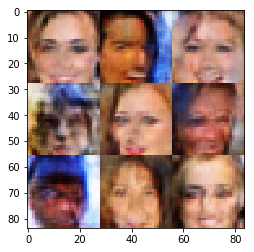

Generator Loss: 0.8190 ........ Discriminator Loss: 1.5041
Generator Loss: 0.4293 ........ Discriminator Loss: 1.7991
Generator Loss: 0.8083 ........ Discriminator Loss: 1.3657
Generator Loss: 0.7001 ........ Discriminator Loss: 1.4672
Generator Loss: 1.0696 ........ Discriminator Loss: 1.2901
Generator Loss: 0.8891 ........ Discriminator Loss: 1.3458
Generator Loss: 0.7164 ........ Discriminator Loss: 1.5040
Generator Loss: 0.6902 ........ Discriminator Loss: 1.6220
Generator Loss: 0.6482 ........ Discriminator Loss: 1.3073
Generator Loss: 0.7772 ........ Discriminator Loss: 1.5153


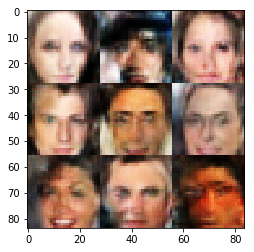

Generator Loss: 0.8002 ........ Discriminator Loss: 1.1266
Generator Loss: 0.5481 ........ Discriminator Loss: 1.4009
Generator Loss: 0.5809 ........ Discriminator Loss: 1.6444
Generator Loss: 0.5102 ........ Discriminator Loss: 1.7010
Generator Loss: 0.6264 ........ Discriminator Loss: 1.3496
Generator Loss: 0.4128 ........ Discriminator Loss: 1.7174
Generator Loss: 0.4803 ........ Discriminator Loss: 1.6555
Generator Loss: 0.6479 ........ Discriminator Loss: 1.5563
Generator Loss: 0.9219 ........ Discriminator Loss: 1.5013
Generator Loss: 0.5095 ........ Discriminator Loss: 1.5697


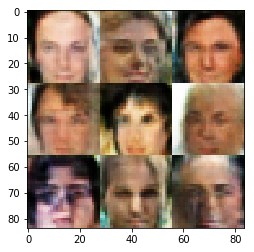

Generator Loss: 0.7628 ........ Discriminator Loss: 1.4563
Generator Loss: 0.7418 ........ Discriminator Loss: 1.3169
Generator Loss: 0.7208 ........ Discriminator Loss: 1.2599
Generator Loss: 0.5760 ........ Discriminator Loss: 1.2193
Generator Loss: 0.7654 ........ Discriminator Loss: 1.4189
Generator Loss: 1.0315 ........ Discriminator Loss: 1.3417
Generator Loss: 0.6855 ........ Discriminator Loss: 1.3491
Generator Loss: 0.8143 ........ Discriminator Loss: 1.3051
Generator Loss: 0.4340 ........ Discriminator Loss: 1.7769
Generator Loss: 0.4686 ........ Discriminator Loss: 1.6082


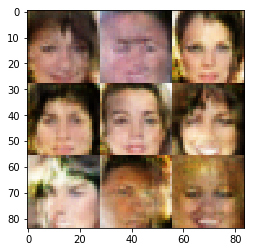

Generator Loss: 0.6145 ........ Discriminator Loss: 1.4683
Generator Loss: 0.9510 ........ Discriminator Loss: 1.2410
Generator Loss: 0.5529 ........ Discriminator Loss: 1.3631
Generator Loss: 0.9254 ........ Discriminator Loss: 1.1951
Generator Loss: 0.9750 ........ Discriminator Loss: 1.3112
Generator Loss: 0.6616 ........ Discriminator Loss: 1.2948
Generator Loss: 0.8217 ........ Discriminator Loss: 1.1962
Generator Loss: 0.5602 ........ Discriminator Loss: 1.3454
Generator Loss: 0.6409 ........ Discriminator Loss: 1.3941
Generator Loss: 0.5149 ........ Discriminator Loss: 1.4244


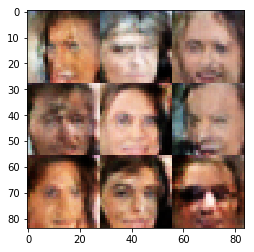

Generator Loss: 0.6693 ........ Discriminator Loss: 1.2678
Generator Loss: 1.2481 ........ Discriminator Loss: 1.3061
Generator Loss: 0.6040 ........ Discriminator Loss: 1.4837
Generator Loss: 0.4430 ........ Discriminator Loss: 1.2957
Generator Loss: 0.6862 ........ Discriminator Loss: 1.5417
Generator Loss: 0.8263 ........ Discriminator Loss: 1.3774
Generator Loss: 0.6353 ........ Discriminator Loss: 1.8316
Generator Loss: 0.6980 ........ Discriminator Loss: 1.4690
Generator Loss: 0.5409 ........ Discriminator Loss: 1.6890
Generator Loss: 1.0926 ........ Discriminator Loss: 1.3808


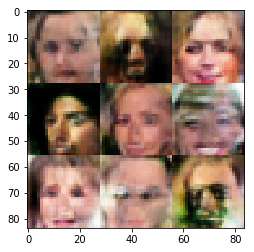

Generator Loss: 0.6617 ........ Discriminator Loss: 1.3455
Generator Loss: 0.5925 ........ Discriminator Loss: 1.5220
Generator Loss: 0.9204 ........ Discriminator Loss: 1.4705
Generator Loss: 0.8554 ........ Discriminator Loss: 1.3864
Generator Loss: 0.8347 ........ Discriminator Loss: 1.5383
Generator Loss: 0.7174 ........ Discriminator Loss: 1.4677
Generator Loss: 0.8261 ........ Discriminator Loss: 1.3575
Generator Loss: 1.2113 ........ Discriminator Loss: 1.1910
Generator Loss: 0.5891 ........ Discriminator Loss: 1.5321
Generator Loss: 0.6631 ........ Discriminator Loss: 1.5217


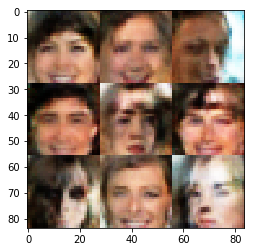

Generator Loss: 0.5360 ........ Discriminator Loss: 1.4818
Generator Loss: 1.0384 ........ Discriminator Loss: 1.2093
Generator Loss: 0.9479 ........ Discriminator Loss: 1.2513
Generator Loss: 0.9640 ........ Discriminator Loss: 1.5561
Generator Loss: 0.7778 ........ Discriminator Loss: 1.4573
Generator Loss: 0.6057 ........ Discriminator Loss: 1.5444
Generator Loss: 0.6554 ........ Discriminator Loss: 1.4610
Generator Loss: 0.7005 ........ Discriminator Loss: 1.1936
Generator Loss: 1.2447 ........ Discriminator Loss: 1.3700
Generator Loss: 0.5494 ........ Discriminator Loss: 1.5816


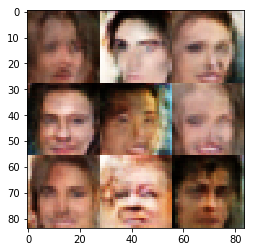

Generator Loss: 0.8356 ........ Discriminator Loss: 1.3207
Generator Loss: 1.1055 ........ Discriminator Loss: 1.3484
Generator Loss: 0.6182 ........ Discriminator Loss: 1.5514
Generator Loss: 0.8947 ........ Discriminator Loss: 1.3603
Generator Loss: 0.6475 ........ Discriminator Loss: 1.5433
Generator Loss: 0.6461 ........ Discriminator Loss: 1.2466
Generator Loss: 0.4767 ........ Discriminator Loss: 1.3429
Generator Loss: 0.7842 ........ Discriminator Loss: 1.4363
Generator Loss: 0.6275 ........ Discriminator Loss: 1.6567
Generator Loss: 0.7380 ........ Discriminator Loss: 1.3362


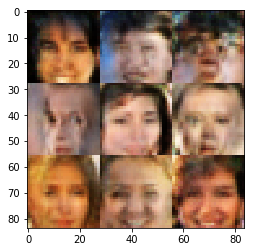

Generator Loss: 1.1289 ........ Discriminator Loss: 1.5444
Generator Loss: 0.6294 ........ Discriminator Loss: 1.5365
Generator Loss: 0.5530 ........ Discriminator Loss: 1.4296
Generator Loss: 0.6738 ........ Discriminator Loss: 1.5426
Generator Loss: 0.5466 ........ Discriminator Loss: 1.5059
Generator Loss: 0.7293 ........ Discriminator Loss: 1.4890
Generator Loss: 0.7235 ........ Discriminator Loss: 1.6460
Generator Loss: 0.5914 ........ Discriminator Loss: 1.2277
Generator Loss: 0.9038 ........ Discriminator Loss: 1.3572
Generator Loss: 0.6895 ........ Discriminator Loss: 1.6919


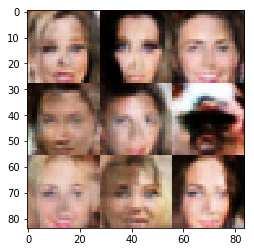

Generator Loss: 0.7831 ........ Discriminator Loss: 1.3583
Generator Loss: 0.7852 ........ Discriminator Loss: 1.1633
Generator Loss: 0.6106 ........ Discriminator Loss: 1.4361
Generator Loss: 0.9727 ........ Discriminator Loss: 1.3616
Generator Loss: 0.7628 ........ Discriminator Loss: 1.2733
Generator Loss: 0.5776 ........ Discriminator Loss: 1.3484
Generator Loss: 0.7888 ........ Discriminator Loss: 1.6548
Generator Loss: 1.0678 ........ Discriminator Loss: 1.3358
Generator Loss: 0.6048 ........ Discriminator Loss: 1.6504
Generator Loss: 0.7718 ........ Discriminator Loss: 1.3941


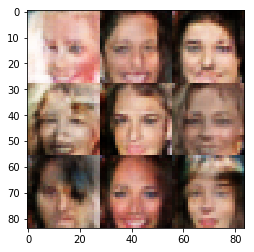

Generator Loss: 0.6640 ........ Discriminator Loss: 1.4775
Generator Loss: 0.9340 ........ Discriminator Loss: 1.2673
Generator Loss: 0.5659 ........ Discriminator Loss: 1.4153
Generator Loss: 0.4743 ........ Discriminator Loss: 1.8659
Generator Loss: 0.6668 ........ Discriminator Loss: 1.6365
Generator Loss: 0.4674 ........ Discriminator Loss: 1.7178
Generator Loss: 0.5600 ........ Discriminator Loss: 1.5127
Generator Loss: 0.6589 ........ Discriminator Loss: 1.4383
Generator Loss: 0.8920 ........ Discriminator Loss: 1.3979
Generator Loss: 0.7616 ........ Discriminator Loss: 1.3338


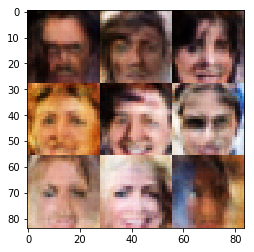

Generator Loss: 0.7213 ........ Discriminator Loss: 1.3101
Generator Loss: 0.6149 ........ Discriminator Loss: 1.7168
Generator Loss: 0.3477 ........ Discriminator Loss: 1.5921
Generator Loss: 0.6972 ........ Discriminator Loss: 1.6047
Generator Loss: 1.0197 ........ Discriminator Loss: 1.2196
Generator Loss: 0.5359 ........ Discriminator Loss: 1.2979
Generator Loss: 0.6972 ........ Discriminator Loss: 1.2286
Generator Loss: 0.6303 ........ Discriminator Loss: 1.4949
Generator Loss: 1.0408 ........ Discriminator Loss: 1.2350
Generator Loss: 0.7379 ........ Discriminator Loss: 1.4594


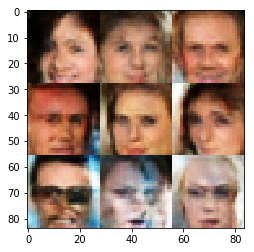

Generator Loss: 0.6536 ........ Discriminator Loss: 1.5911
Generator Loss: 0.7341 ........ Discriminator Loss: 1.4067
Generator Loss: 0.4874 ........ Discriminator Loss: 1.8864
Generator Loss: 0.8513 ........ Discriminator Loss: 1.4526
Generator Loss: 0.6187 ........ Discriminator Loss: 1.5081
Generator Loss: 0.8024 ........ Discriminator Loss: 1.6118
Generator Loss: 0.6223 ........ Discriminator Loss: 1.3011
Generator Loss: 0.5752 ........ Discriminator Loss: 1.2720
Generator Loss: 0.6232 ........ Discriminator Loss: 1.4104
Generator Loss: 0.9428 ........ Discriminator Loss: 1.3326


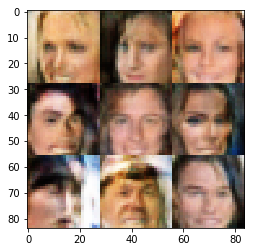

Generator Loss: 0.7641 ........ Discriminator Loss: 1.4394
Generator Loss: 0.5482 ........ Discriminator Loss: 1.4277
Generator Loss: 0.5484 ........ Discriminator Loss: 1.8691
Generator Loss: 0.6922 ........ Discriminator Loss: 1.7577
Generator Loss: 0.3820 ........ Discriminator Loss: 1.4505
Generator Loss: 1.2277 ........ Discriminator Loss: 1.4281
Generator Loss: 0.7450 ........ Discriminator Loss: 1.6912
Generator Loss: 0.8473 ........ Discriminator Loss: 1.4533
Generator Loss: 1.1813 ........ Discriminator Loss: 1.6929
Generator Loss: 0.5689 ........ Discriminator Loss: 1.4358


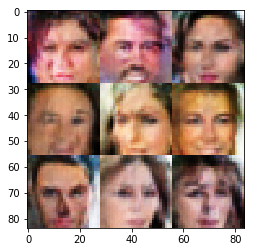

Generator Loss: 1.1930 ........ Discriminator Loss: 1.6192
Generator Loss: 0.5896 ........ Discriminator Loss: 1.5794
Generator Loss: 0.7760 ........ Discriminator Loss: 1.4901
Generator Loss: 0.6546 ........ Discriminator Loss: 1.4422
Generator Loss: 0.3648 ........ Discriminator Loss: 1.6088
Generator Loss: 0.6605 ........ Discriminator Loss: 1.6620
Generator Loss: 0.9573 ........ Discriminator Loss: 1.0618
Generator Loss: 0.7905 ........ Discriminator Loss: 1.5090
Generator Loss: 0.8765 ........ Discriminator Loss: 1.1786
Generator Loss: 0.6917 ........ Discriminator Loss: 1.6522


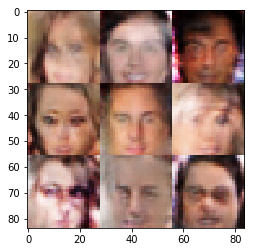

Generator Loss: 0.7430 ........ Discriminator Loss: 1.6481
Generator Loss: 0.4691 ........ Discriminator Loss: 1.8806
Generator Loss: 0.5382 ........ Discriminator Loss: 1.5364
Generator Loss: 1.0178 ........ Discriminator Loss: 1.3525
Generator Loss: 0.7328 ........ Discriminator Loss: 1.4503
Generator Loss: 0.8294 ........ Discriminator Loss: 1.6961
Generator Loss: 0.6119 ........ Discriminator Loss: 1.3446
Generator Loss: 0.7372 ........ Discriminator Loss: 1.5724
Generator Loss: 0.5796 ........ Discriminator Loss: 1.5358
Generator Loss: 0.6324 ........ Discriminator Loss: 1.4495


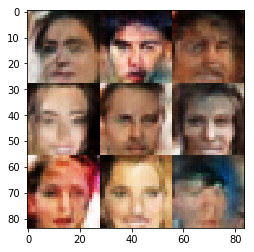

Generator Loss: 0.6776 ........ Discriminator Loss: 1.4189
Generator Loss: 0.7652 ........ Discriminator Loss: 1.4137
Generator Loss: 0.8213 ........ Discriminator Loss: 1.3169
Generator Loss: 0.5637 ........ Discriminator Loss: 1.6359
Generator Loss: 0.6528 ........ Discriminator Loss: 1.5407
Generator Loss: 0.6454 ........ Discriminator Loss: 1.4309
Generator Loss: 0.5771 ........ Discriminator Loss: 1.4747
Generator Loss: 0.7315 ........ Discriminator Loss: 1.2162
Generator Loss: 0.4571 ........ Discriminator Loss: 1.7614
Generator Loss: 1.0240 ........ Discriminator Loss: 1.3088


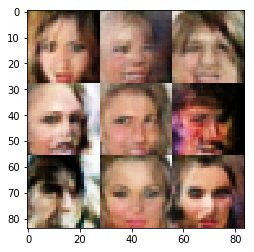

Generator Loss: 0.5063 ........ Discriminator Loss: 1.3406
Generator Loss: 1.0522 ........ Discriminator Loss: 1.3856
Generator Loss: 1.1067 ........ Discriminator Loss: 1.2288
Generator Loss: 0.6711 ........ Discriminator Loss: 1.5384
Generator Loss: 0.9043 ........ Discriminator Loss: 1.3101
Generator Loss: 0.8646 ........ Discriminator Loss: 1.5143
Generator Loss: 0.9819 ........ Discriminator Loss: 1.4686
Generator Loss: 0.6163 ........ Discriminator Loss: 1.6743
Generator Loss: 0.5397 ........ Discriminator Loss: 1.4128
Generator Loss: 0.6738 ........ Discriminator Loss: 1.2675


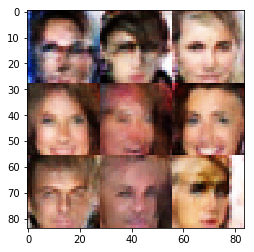

Generator Loss: 0.5720 ........ Discriminator Loss: 1.4880
Generator Loss: 0.5955 ........ Discriminator Loss: 1.6043
Generator Loss: 0.9864 ........ Discriminator Loss: 1.3359
Generator Loss: 0.9573 ........ Discriminator Loss: 1.2894
Generator Loss: 0.8820 ........ Discriminator Loss: 1.3551
Generator Loss: 0.8514 ........ Discriminator Loss: 1.4471
Generator Loss: 0.6228 ........ Discriminator Loss: 1.3449
Generator Loss: 0.8235 ........ Discriminator Loss: 1.2238
Generator Loss: 0.7660 ........ Discriminator Loss: 1.3068
Generator Loss: 1.0001 ........ Discriminator Loss: 1.4510


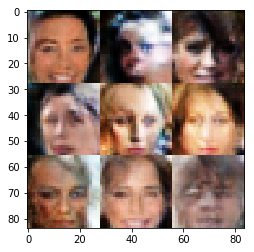

Generator Loss: 0.6463 ........ Discriminator Loss: 1.4879
Generator Loss: 0.9048 ........ Discriminator Loss: 1.2364
Generator Loss: 0.8077 ........ Discriminator Loss: 1.5989
Generator Loss: 0.8934 ........ Discriminator Loss: 1.6337
Generator Loss: 0.4987 ........ Discriminator Loss: 1.6382
Generator Loss: 1.2003 ........ Discriminator Loss: 1.3894
Generator Loss: 0.4747 ........ Discriminator Loss: 1.5252
Generator Loss: 1.2338 ........ Discriminator Loss: 1.4439
Generator Loss: 0.5256 ........ Discriminator Loss: 1.4620
Generator Loss: 0.8648 ........ Discriminator Loss: 1.4793


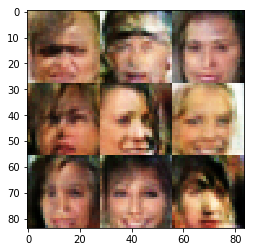

Generator Loss: 0.6023 ........ Discriminator Loss: 1.4040
Generator Loss: 0.9728 ........ Discriminator Loss: 1.4888
Generator Loss: 0.8266 ........ Discriminator Loss: 1.3772
Generator Loss: 0.5765 ........ Discriminator Loss: 1.5576
Generator Loss: 0.6487 ........ Discriminator Loss: 1.3323
Generator Loss: 0.6758 ........ Discriminator Loss: 1.3623
Generator Loss: 0.7085 ........ Discriminator Loss: 1.3839
Generator Loss: 0.8677 ........ Discriminator Loss: 1.6543
Generator Loss: 0.8817 ........ Discriminator Loss: 1.0824
Generator Loss: 0.8665 ........ Discriminator Loss: 1.4262


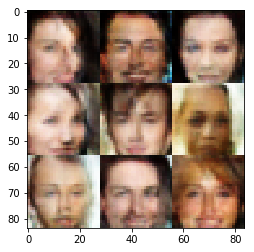

Generator Loss: 0.8513 ........ Discriminator Loss: 1.6310
Generator Loss: 0.7506 ........ Discriminator Loss: 1.4618
Generator Loss: 0.9634 ........ Discriminator Loss: 1.2944
Generator Loss: 0.8647 ........ Discriminator Loss: 1.2169
Generator Loss: 1.1871 ........ Discriminator Loss: 1.3455
Generator Loss: 1.0384 ........ Discriminator Loss: 1.3554
Generator Loss: 0.7624 ........ Discriminator Loss: 1.3552
Generator Loss: 1.1998 ........ Discriminator Loss: 1.2623
Generator Loss: 0.7753 ........ Discriminator Loss: 1.5291
Generator Loss: 0.6831 ........ Discriminator Loss: 1.5066


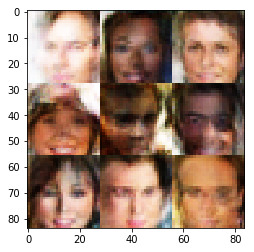

Generator Loss: 0.6574 ........ Discriminator Loss: 1.2558
Generator Loss: 0.6667 ........ Discriminator Loss: 1.3882
Generator Loss: 0.9480 ........ Discriminator Loss: 1.3586
Generator Loss: 0.8862 ........ Discriminator Loss: 1.3388
Generator Loss: 0.7322 ........ Discriminator Loss: 1.2181
Generator Loss: 0.8269 ........ Discriminator Loss: 1.4626
Generator Loss: 0.7962 ........ Discriminator Loss: 1.1828
Generator Loss: 0.7955 ........ Discriminator Loss: 1.4641
Generator Loss: 0.5894 ........ Discriminator Loss: 1.4466
Generator Loss: 0.7925 ........ Discriminator Loss: 1.2745


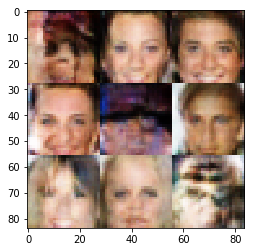

Generator Loss: 0.7468 ........ Discriminator Loss: 1.5038
Generator Loss: 0.5934 ........ Discriminator Loss: 1.5668
Generator Loss: 0.7812 ........ Discriminator Loss: 1.2749
Generator Loss: 0.5833 ........ Discriminator Loss: 1.5620
Generator Loss: 1.1066 ........ Discriminator Loss: 1.3942
Generator Loss: 0.9594 ........ Discriminator Loss: 1.3640
Generator Loss: 0.8468 ........ Discriminator Loss: 1.4481
Generator Loss: 0.6310 ........ Discriminator Loss: 1.5160
Generator Loss: 0.6707 ........ Discriminator Loss: 1.2985
Generator Loss: 0.8988 ........ Discriminator Loss: 1.3930


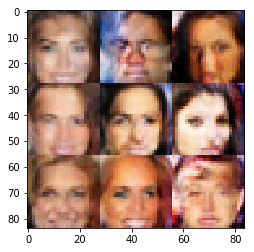

Generator Loss: 0.7820 ........ Discriminator Loss: 1.4406
Generator Loss: 0.5321 ........ Discriminator Loss: 1.6030
Generator Loss: 0.5073 ........ Discriminator Loss: 1.5713
Generator Loss: 0.6803 ........ Discriminator Loss: 1.1341
Generator Loss: 0.9682 ........ Discriminator Loss: 1.2819
Generator Loss: 0.5594 ........ Discriminator Loss: 1.5621
Generator Loss: 0.6854 ........ Discriminator Loss: 1.3591
Generator Loss: 0.4625 ........ Discriminator Loss: 1.6799
Generator Loss: 0.7700 ........ Discriminator Loss: 1.5112
Generator Loss: 1.1128 ........ Discriminator Loss: 1.3153


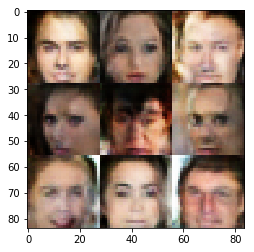

Generator Loss: 0.8409 ........ Discriminator Loss: 1.5873
Generator Loss: 0.7960 ........ Discriminator Loss: 1.3478
Generator Loss: 0.6097 ........ Discriminator Loss: 1.6549
Generator Loss: 1.4837 ........ Discriminator Loss: 1.1480
Generator Loss: 0.6806 ........ Discriminator Loss: 1.2708
Generator Loss: 1.2140 ........ Discriminator Loss: 1.2165
Generator Loss: 0.7162 ........ Discriminator Loss: 1.3582
Generator Loss: 0.6260 ........ Discriminator Loss: 1.3747
Generator Loss: 1.1510 ........ Discriminator Loss: 1.2794
Generator Loss: 0.6425 ........ Discriminator Loss: 1.5841


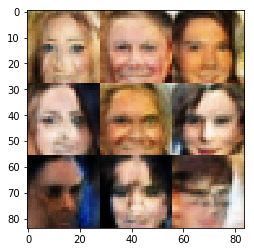

Generator Loss: 0.4732 ........ Discriminator Loss: 1.6030
Generator Loss: 0.8228 ........ Discriminator Loss: 1.2618
Generator Loss: 0.9571 ........ Discriminator Loss: 1.1200
Generator Loss: 0.6502 ........ Discriminator Loss: 1.1765
Generator Loss: 0.8653 ........ Discriminator Loss: 1.5530
Generator Loss: 1.0616 ........ Discriminator Loss: 1.3663
Generator Loss: 0.6599 ........ Discriminator Loss: 1.4596
Generator Loss: 0.9623 ........ Discriminator Loss: 1.3186
Generator Loss: 0.6144 ........ Discriminator Loss: 1.5460
Generator Loss: 0.5578 ........ Discriminator Loss: 1.5246


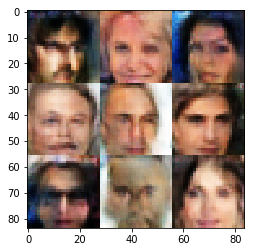

Generator Loss: 0.7351 ........ Discriminator Loss: 1.3787
Generator Loss: 0.6187 ........ Discriminator Loss: 1.4889
Generator Loss: 0.7635 ........ Discriminator Loss: 1.4514
Generator Loss: 0.7020 ........ Discriminator Loss: 1.3443
Generator Loss: 1.0710 ........ Discriminator Loss: 1.3655
Generator Loss: 0.7618 ........ Discriminator Loss: 1.2732
Generator Loss: 0.7091 ........ Discriminator Loss: 1.4121
Generator Loss: 0.7327 ........ Discriminator Loss: 1.4213
Generator Loss: 0.6894 ........ Discriminator Loss: 1.7305
Generator Loss: 0.7836 ........ Discriminator Loss: 1.5284


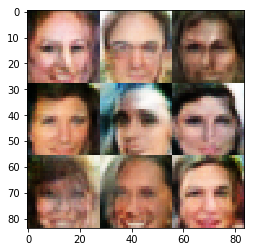

Generator Loss: 1.0534 ........ Discriminator Loss: 1.3044
Generator Loss: 0.7508 ........ Discriminator Loss: 1.4525
Generator Loss: 0.9097 ........ Discriminator Loss: 1.1728
Generator Loss: 0.5423 ........ Discriminator Loss: 1.3628
Generator Loss: 0.7160 ........ Discriminator Loss: 1.4442
Generator Loss: 0.7442 ........ Discriminator Loss: 1.1352
Generator Loss: 0.5682 ........ Discriminator Loss: 1.4242
Generator Loss: 0.4405 ........ Discriminator Loss: 1.7224
Generator Loss: 0.7858 ........ Discriminator Loss: 1.5656
Generator Loss: 0.6961 ........ Discriminator Loss: 1.2989


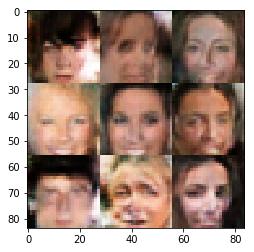

Generator Loss: 0.7266 ........ Discriminator Loss: 1.3363
Generator Loss: 0.4692 ........ Discriminator Loss: 1.4245
Generator Loss: 1.0019 ........ Discriminator Loss: 1.5359
Generator Loss: 0.4577 ........ Discriminator Loss: 1.4771
Generator Loss: 0.6261 ........ Discriminator Loss: 1.3406
Generator Loss: 0.7777 ........ Discriminator Loss: 1.3921
Generator Loss: 0.8746 ........ Discriminator Loss: 1.6152
Generator Loss: 0.7085 ........ Discriminator Loss: 1.3375
Generator Loss: 0.7011 ........ Discriminator Loss: 1.2604
Generator Loss: 0.6799 ........ Discriminator Loss: 1.3258


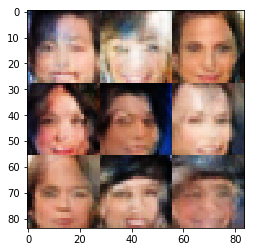

Generator Loss: 0.8101 ........ Discriminator Loss: 1.4480
Generator Loss: 0.5770 ........ Discriminator Loss: 1.2310
Generator Loss: 0.8940 ........ Discriminator Loss: 1.4402
Generator Loss: 0.7191 ........ Discriminator Loss: 1.4138
Generator Loss: 0.7913 ........ Discriminator Loss: 1.2418
Generator Loss: 0.8048 ........ Discriminator Loss: 1.2964
Generator Loss: 0.9173 ........ Discriminator Loss: 1.6274
Generator Loss: 0.4148 ........ Discriminator Loss: 1.5063
Generator Loss: 0.9845 ........ Discriminator Loss: 1.2392
Generator Loss: 1.0379 ........ Discriminator Loss: 1.1407


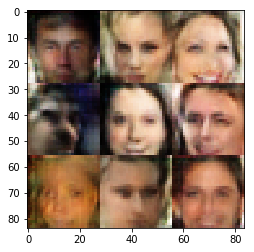

Generator Loss: 0.7997 ........ Discriminator Loss: 1.1969
Generator Loss: 1.2189 ........ Discriminator Loss: 1.2196
Generator Loss: 1.3288 ........ Discriminator Loss: 1.1239
Generator Loss: 0.8924 ........ Discriminator Loss: 1.3864
Generator Loss: 0.3944 ........ Discriminator Loss: 1.4911
Generator Loss: 0.5253 ........ Discriminator Loss: 1.6019
Generator Loss: 0.8784 ........ Discriminator Loss: 1.1294
Generator Loss: 0.8507 ........ Discriminator Loss: 1.3862
Generator Loss: 0.8143 ........ Discriminator Loss: 1.3337
Generator Loss: 0.9712 ........ Discriminator Loss: 1.2980


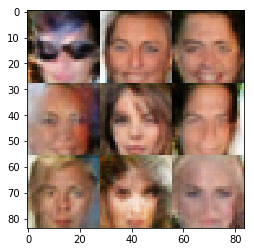

Generator Loss: 1.4597 ........ Discriminator Loss: 1.4349
Generator Loss: 0.6587 ........ Discriminator Loss: 1.4388
Generator Loss: 0.7318 ........ Discriminator Loss: 1.4616
Generator Loss: 0.9487 ........ Discriminator Loss: 1.3243
Generator Loss: 1.0004 ........ Discriminator Loss: 1.2193
Generator Loss: 0.6903 ........ Discriminator Loss: 1.3322
Generator Loss: 0.9456 ........ Discriminator Loss: 1.3011
Generator Loss: 0.7562 ........ Discriminator Loss: 1.1860
Generator Loss: 0.7377 ........ Discriminator Loss: 1.5961
Generator Loss: 0.6191 ........ Discriminator Loss: 1.5742


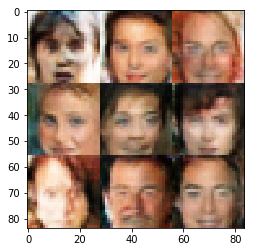

Generator Loss: 0.6278 ........ Discriminator Loss: 1.7390
Generator Loss: 0.4910 ........ Discriminator Loss: 2.0983
Generator Loss: 0.9753 ........ Discriminator Loss: 1.2664
Generator Loss: 0.7889 ........ Discriminator Loss: 1.4249
Generator Loss: 0.7650 ........ Discriminator Loss: 1.3609
Generator Loss: 0.5867 ........ Discriminator Loss: 1.4051
Generator Loss: 0.6837 ........ Discriminator Loss: 1.4258
Generator Loss: 0.6586 ........ Discriminator Loss: 1.4274
Generator Loss: 0.8495 ........ Discriminator Loss: 1.3133
Generator Loss: 0.6934 ........ Discriminator Loss: 1.3511


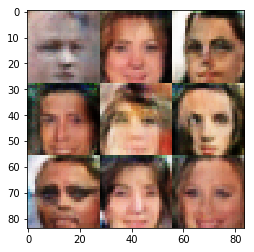

Generator Loss: 0.6261 ........ Discriminator Loss: 1.5101
Generator Loss: 0.4808 ........ Discriminator Loss: 1.5758
Generator Loss: 0.6297 ........ Discriminator Loss: 1.4826
Generator Loss: 0.8537 ........ Discriminator Loss: 1.2248
Generator Loss: 0.9859 ........ Discriminator Loss: 1.2139
Generator Loss: 0.5422 ........ Discriminator Loss: 1.3651
Generator Loss: 0.5546 ........ Discriminator Loss: 1.3424
Generator Loss: 0.6819 ........ Discriminator Loss: 1.4527
Generator Loss: 0.7333 ........ Discriminator Loss: 1.2859
Generator Loss: 0.9191 ........ Discriminator Loss: 1.3987


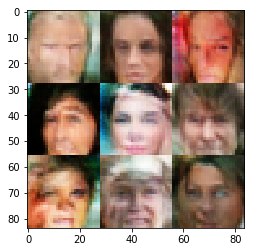

Generator Loss: 0.7082 ........ Discriminator Loss: 1.2728
Generator Loss: 0.8504 ........ Discriminator Loss: 1.3397
Generator Loss: 0.8632 ........ Discriminator Loss: 1.2084
Generator Loss: 0.6242 ........ Discriminator Loss: 1.5948
Generator Loss: 0.8215 ........ Discriminator Loss: 1.4558
Generator Loss: 0.6694 ........ Discriminator Loss: 1.2843
Generator Loss: 0.7599 ........ Discriminator Loss: 1.2798
Generator Loss: 0.5615 ........ Discriminator Loss: 1.5956
Generator Loss: 0.6580 ........ Discriminator Loss: 1.3755
Generator Loss: 0.6513 ........ Discriminator Loss: 1.3840


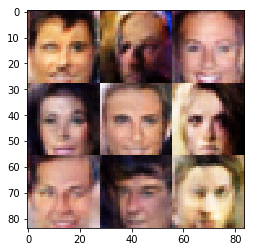

Generator Loss: 1.0123 ........ Discriminator Loss: 1.1990
Generator Loss: 0.5404 ........ Discriminator Loss: 1.8861
Generator Loss: 0.9367 ........ Discriminator Loss: 1.5213
Generator Loss: 0.4169 ........ Discriminator Loss: 1.6327
Generator Loss: 0.5955 ........ Discriminator Loss: 1.3590
Generator Loss: 0.7034 ........ Discriminator Loss: 1.5407
Generator Loss: 0.8137 ........ Discriminator Loss: 1.3465
Generator Loss: 0.8445 ........ Discriminator Loss: 1.2359
Generator Loss: 1.0439 ........ Discriminator Loss: 1.5464
Generator Loss: 0.9865 ........ Discriminator Loss: 1.2288


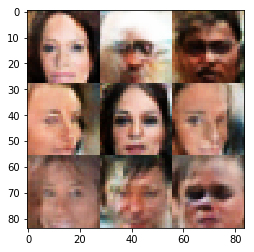

Generator Loss: 0.7521 ........ Discriminator Loss: 1.2937
Generator Loss: 0.8853 ........ Discriminator Loss: 1.2541
Generator Loss: 0.8619 ........ Discriminator Loss: 1.2135
Generator Loss: 0.5299 ........ Discriminator Loss: 1.2598
Generator Loss: 0.6198 ........ Discriminator Loss: 1.7193
Generator Loss: 0.6688 ........ Discriminator Loss: 1.3183
Generator Loss: 0.4594 ........ Discriminator Loss: 1.5099
Generator Loss: 0.5911 ........ Discriminator Loss: 1.6515
Generator Loss: 0.8740 ........ Discriminator Loss: 1.3398
Generator Loss: 0.3379 ........ Discriminator Loss: 1.5317


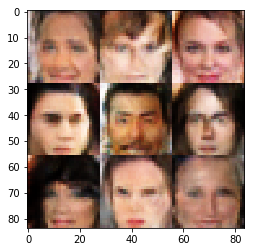

Generator Loss: 0.5154 ........ Discriminator Loss: 1.6851
Generator Loss: 0.6672 ........ Discriminator Loss: 1.5517
Generator Loss: 0.8546 ........ Discriminator Loss: 1.3476
Generator Loss: 0.7134 ........ Discriminator Loss: 1.5202
Generator Loss: 0.6730 ........ Discriminator Loss: 1.1602
Generator Loss: 0.7303 ........ Discriminator Loss: 1.2402
Generator Loss: 0.6238 ........ Discriminator Loss: 1.5833
Generator Loss: 0.6109 ........ Discriminator Loss: 1.6179
Generator Loss: 0.5995 ........ Discriminator Loss: 1.4645
Generator Loss: 0.7447 ........ Discriminator Loss: 1.3942


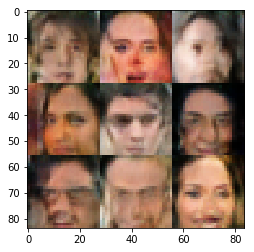

Generator Loss: 1.1121 ........ Discriminator Loss: 1.3388
Generator Loss: 0.6199 ........ Discriminator Loss: 1.7011
Generator Loss: 0.9061 ........ Discriminator Loss: 1.4892
Generator Loss: 0.8273 ........ Discriminator Loss: 1.3904
Generator Loss: 0.5673 ........ Discriminator Loss: 1.4904
Generator Loss: 0.5337 ........ Discriminator Loss: 1.4045
Generator Loss: 0.8306 ........ Discriminator Loss: 1.3111
Generator Loss: 0.5449 ........ Discriminator Loss: 1.4774
Generator Loss: 0.5750 ........ Discriminator Loss: 1.3681
Generator Loss: 0.8675 ........ Discriminator Loss: 1.4678


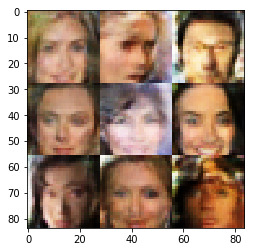

Generator Loss: 1.0435 ........ Discriminator Loss: 1.3851
Generator Loss: 0.5269 ........ Discriminator Loss: 1.3536
Generator Loss: 0.8307 ........ Discriminator Loss: 1.5560
Generator Loss: 0.9267 ........ Discriminator Loss: 1.2019
Generator Loss: 0.9361 ........ Discriminator Loss: 1.3225
Generator Loss: 0.5081 ........ Discriminator Loss: 1.5236
Generator Loss: 0.8607 ........ Discriminator Loss: 1.3219
Generator Loss: 0.7320 ........ Discriminator Loss: 1.5086
Generator Loss: 1.0642 ........ Discriminator Loss: 1.4447
Generator Loss: 0.7137 ........ Discriminator Loss: 1.3233


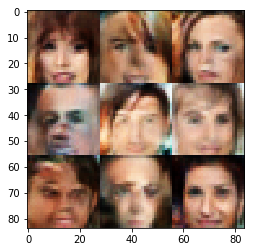

Generator Loss: 0.6506 ........ Discriminator Loss: 1.2828
Generator Loss: 0.6249 ........ Discriminator Loss: 1.3862
Generator Loss: 0.8693 ........ Discriminator Loss: 1.4610
Generator Loss: 0.9678 ........ Discriminator Loss: 1.1053
Generator Loss: 1.4567 ........ Discriminator Loss: 1.1335
Generator Loss: 0.4604 ........ Discriminator Loss: 1.8294
Generator Loss: 0.6125 ........ Discriminator Loss: 1.5933
Generator Loss: 0.9847 ........ Discriminator Loss: 1.2648
Generator Loss: 0.7401 ........ Discriminator Loss: 1.2891
Generator Loss: 0.8927 ........ Discriminator Loss: 1.5241


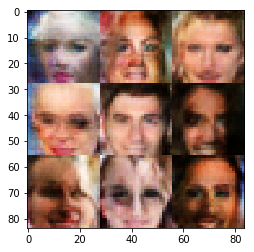

Generator Loss: 0.6317 ........ Discriminator Loss: 1.3407
Generator Loss: 0.6461 ........ Discriminator Loss: 1.3698
Generator Loss: 0.6753 ........ Discriminator Loss: 1.5026
Generator Loss: 0.9530 ........ Discriminator Loss: 1.4170
Generator Loss: 0.9278 ........ Discriminator Loss: 1.7302
Generator Loss: 0.6616 ........ Discriminator Loss: 1.5531
Generator Loss: 0.8626 ........ Discriminator Loss: 1.3970
Generator Loss: 0.9251 ........ Discriminator Loss: 1.3273
Generator Loss: 0.7035 ........ Discriminator Loss: 1.3475
Generator Loss: 0.8091 ........ Discriminator Loss: 1.5444


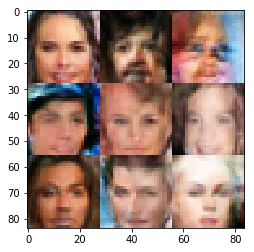

Generator Loss: 0.6656 ........ Discriminator Loss: 1.6294
Generator Loss: 0.6401 ........ Discriminator Loss: 1.3788
Generator Loss: 0.4829 ........ Discriminator Loss: 1.4794
Generator Loss: 0.6368 ........ Discriminator Loss: 1.4330
Generator Loss: 0.6810 ........ Discriminator Loss: 1.5176
Generator Loss: 0.8357 ........ Discriminator Loss: 1.3442
Generator Loss: 0.7659 ........ Discriminator Loss: 1.6045
Generator Loss: 0.5101 ........ Discriminator Loss: 1.5498
Generator Loss: 0.6895 ........ Discriminator Loss: 1.5427
Generator Loss: 0.8872 ........ Discriminator Loss: 1.2748


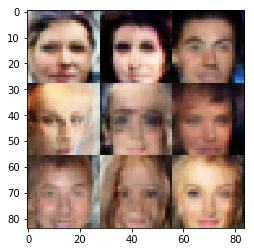

Generator Loss: 0.7595 ........ Discriminator Loss: 1.4086
Generator Loss: 0.5642 ........ Discriminator Loss: 1.4842
Generator Loss: 0.6799 ........ Discriminator Loss: 1.5584
Generator Loss: 0.8139 ........ Discriminator Loss: 1.4885
Generator Loss: 0.7422 ........ Discriminator Loss: 1.2381
Generator Loss: 0.6395 ........ Discriminator Loss: 1.2907
Generator Loss: 0.6224 ........ Discriminator Loss: 1.2079
Generator Loss: 0.8676 ........ Discriminator Loss: 1.2598
Generator Loss: 0.6730 ........ Discriminator Loss: 1.6293
Generator Loss: 0.6537 ........ Discriminator Loss: 1.3079


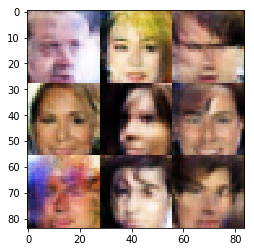

Generator Loss: 0.7265 ........ Discriminator Loss: 1.2543
Generator Loss: 0.9719 ........ Discriminator Loss: 1.2757
Generator Loss: 0.8976 ........ Discriminator Loss: 1.3448
Generator Loss: 0.7583 ........ Discriminator Loss: 1.4936
Generator Loss: 0.8321 ........ Discriminator Loss: 1.3676
Generator Loss: 0.8482 ........ Discriminator Loss: 1.5128
Generator Loss: 0.7228 ........ Discriminator Loss: 1.3535
Generator Loss: 0.9362 ........ Discriminator Loss: 1.4589
Generator Loss: 1.0969 ........ Discriminator Loss: 1.2268
Generator Loss: 0.5625 ........ Discriminator Loss: 1.3474


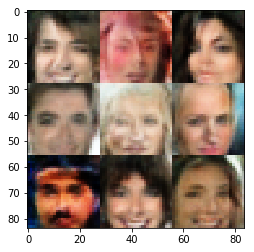

Generator Loss: 0.8386 ........ Discriminator Loss: 1.4584
Generator Loss: 0.7483 ........ Discriminator Loss: 1.3640
Generator Loss: 0.7791 ........ Discriminator Loss: 1.4836
Generator Loss: 0.6666 ........ Discriminator Loss: 1.4391
Generator Loss: 0.8645 ........ Discriminator Loss: 1.3590
Generator Loss: 0.6180 ........ Discriminator Loss: 1.4297
Generator Loss: 0.7925 ........ Discriminator Loss: 1.5948
Generator Loss: 0.7207 ........ Discriminator Loss: 1.3137
Generator Loss: 0.9174 ........ Discriminator Loss: 1.3666
Generator Loss: 0.7862 ........ Discriminator Loss: 1.3526


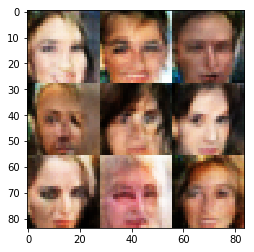

Generator Loss: 0.5443 ........ Discriminator Loss: 1.5398
Generator Loss: 1.2943 ........ Discriminator Loss: 1.2527
Generator Loss: 0.6448 ........ Discriminator Loss: 1.4454
Generator Loss: 0.7030 ........ Discriminator Loss: 1.4979
Generator Loss: 0.7361 ........ Discriminator Loss: 1.3151
Generator Loss: 0.6102 ........ Discriminator Loss: 1.2731
Generator Loss: 0.6248 ........ Discriminator Loss: 1.5616
Generator Loss: 0.7080 ........ Discriminator Loss: 1.4991
Generator Loss: 0.6881 ........ Discriminator Loss: 1.6540
Generator Loss: 0.6353 ........ Discriminator Loss: 1.4885


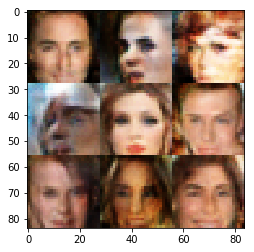

Generator Loss: 0.8159 ........ Discriminator Loss: 1.5126
Generator Loss: 0.8822 ........ Discriminator Loss: 1.2380
Generator Loss: 0.9554 ........ Discriminator Loss: 1.3704
Generator Loss: 0.7211 ........ Discriminator Loss: 1.4103
Generator Loss: 0.8352 ........ Discriminator Loss: 1.5170
Generator Loss: 1.1741 ........ Discriminator Loss: 1.2799
Generator Loss: 0.6941 ........ Discriminator Loss: 1.3831
Generator Loss: 1.0104 ........ Discriminator Loss: 1.3889
Generator Loss: 0.7284 ........ Discriminator Loss: 1.3320
Generator Loss: 0.7409 ........ Discriminator Loss: 1.2878


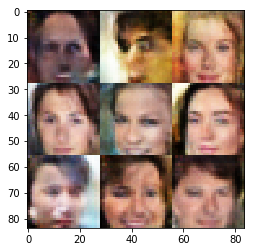

Generator Loss: 0.9669 ........ Discriminator Loss: 1.4561
Generator Loss: 0.8386 ........ Discriminator Loss: 1.3387
Generator Loss: 0.6889 ........ Discriminator Loss: 1.1893
Generator Loss: 0.7105 ........ Discriminator Loss: 1.3126
Generator Loss: 0.6838 ........ Discriminator Loss: 1.6021
Generator Loss: 0.9082 ........ Discriminator Loss: 1.3590
Generator Loss: 0.7949 ........ Discriminator Loss: 1.2734
Generator Loss: 0.6725 ........ Discriminator Loss: 1.4408
Generator Loss: 1.1274 ........ Discriminator Loss: 1.0603
Generator Loss: 0.7989 ........ Discriminator Loss: 1.4196


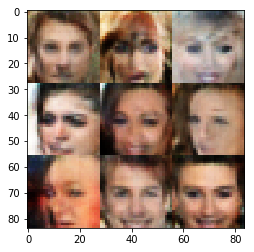

Generator Loss: 0.8930 ........ Discriminator Loss: 1.2502
Generator Loss: 0.5107 ........ Discriminator Loss: 1.4082
Generator Loss: 0.7263 ........ Discriminator Loss: 1.5401
Generator Loss: 0.9076 ........ Discriminator Loss: 1.2697
Generator Loss: 0.5093 ........ Discriminator Loss: 1.4547
Generator Loss: 0.8305 ........ Discriminator Loss: 1.2163
Generator Loss: 0.9338 ........ Discriminator Loss: 1.4094
Generator Loss: 0.5634 ........ Discriminator Loss: 1.3474
Generator Loss: 0.8582 ........ Discriminator Loss: 1.2144
Generator Loss: 1.0330 ........ Discriminator Loss: 1.2865


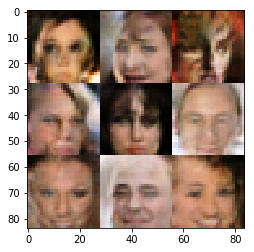

Generator Loss: 0.7946 ........ Discriminator Loss: 1.4583
Generator Loss: 0.6140 ........ Discriminator Loss: 1.7286
Generator Loss: 0.5906 ........ Discriminator Loss: 1.3174
Generator Loss: 0.7880 ........ Discriminator Loss: 1.3604
Generator Loss: 0.7197 ........ Discriminator Loss: 1.3374
Generator Loss: 0.7332 ........ Discriminator Loss: 1.4410
Generator Loss: 0.7520 ........ Discriminator Loss: 1.4093
Generator Loss: 0.4691 ........ Discriminator Loss: 1.4984
Generator Loss: 0.5096 ........ Discriminator Loss: 1.4563
Generator Loss: 0.8091 ........ Discriminator Loss: 1.2558


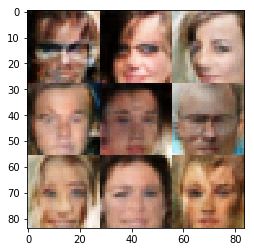

Generator Loss: 0.7814 ........ Discriminator Loss: 1.4553
Generator Loss: 0.6771 ........ Discriminator Loss: 1.6587
Generator Loss: 0.5674 ........ Discriminator Loss: 1.6202
Generator Loss: 0.8419 ........ Discriminator Loss: 1.1885
Generator Loss: 0.8733 ........ Discriminator Loss: 1.3711
Generator Loss: 0.8562 ........ Discriminator Loss: 1.2816
Generator Loss: 0.7732 ........ Discriminator Loss: 1.2980
Generator Loss: 0.4798 ........ Discriminator Loss: 1.6884
Generator Loss: 0.7505 ........ Discriminator Loss: 1.3331
Generator Loss: 0.3962 ........ Discriminator Loss: 1.4865


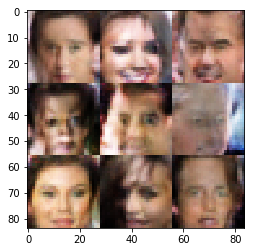

Generator Loss: 0.7353 ........ Discriminator Loss: 1.3229
Generator Loss: 0.5674 ........ Discriminator Loss: 1.3088
Generator Loss: 0.6412 ........ Discriminator Loss: 1.3652
Generator Loss: 1.0056 ........ Discriminator Loss: 1.2690
Generator Loss: 1.1672 ........ Discriminator Loss: 1.2504
Generator Loss: 0.7446 ........ Discriminator Loss: 1.5738
Generator Loss: 1.0493 ........ Discriminator Loss: 1.4102
Generator Loss: 1.0464 ........ Discriminator Loss: 1.6318
Generator Loss: 0.6669 ........ Discriminator Loss: 1.5287
Generator Loss: 0.8888 ........ Discriminator Loss: 1.3394


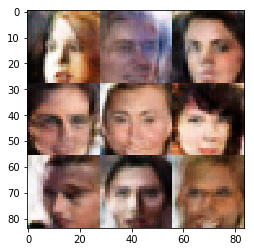

Generator Loss: 0.6772 ........ Discriminator Loss: 1.3949
Generator Loss: 0.7631 ........ Discriminator Loss: 1.4624


In [13]:
batch_size = 20
z_dim = 128
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.